EDA questions:

effect of pool on price

How does having a pool affect property values?

filtering out outliers in price

what does the low end of sale prices look like?

Need to look at lot size more closely on the low end

Does it make sense to do all this EDA then filter the home prices at the end? It might filter out some noise at the last second, but it also makes it harder to detect the more granular noise during the initial EDA.

In [17]:
# Need to add this code after done investigating nulls

# # Converting floats to int

# cols_to_int = ['bedrooms','bathrooms','squareFootage','lotSize','yearBuilt','lastSalePrice','floorCount']

# data[cols_to_int] = data[cols_to_int].astype(int)

# data.info()

In [18]:
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from pickle import dump

In [19]:
# Loading data from SQLite to pandas

path_to_db = '/workspaces/mds8-final-project-bmh/data/raw/rentcast_FL.db'
conn = sqlite3.connect(path_to_db)
query = """SELECT * FROM properties"""
data = pd.read_sql(query, conn)
conn.close()
data.head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,foundationType,garage,garageSpaces,garageType,pool,roomCount,unitCount,viewType
0,"1960-S-Ocean-Blvd,-Manalapan,-FL-33462","1960 S Ocean Blvd, Manalapan, FL 33462",Manalapan,FL,33462,Palm Beach,26.55,-80.04,Single Family,8.00,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
1,"5018-Coquina-Key-Dr-SE,-Saint-Petersburg,-FL-3...","5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,FL,33705,Pinellas,27.72,-82.63,Townhouse,2.00,...,0,2.00,None,0,NaN,None,True,NaN,1.00,Water
2,"1070-Rhonda-Rd,-Jacksonville,-FL-32254","1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,FL,32254,Duval,30.34,-81.72,Single Family,3.00,...,0,1.00,None,1,4.00,Garage,False,NaN,1.00,None
3,"2200-S-Ocean-Dr,-Apt-N108,-Hollywood,-FL-33019","2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,FL,33019,Broward,26.00,-80.12,Condo,2.00,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
4,"6065-Parkwalk-Dr,-Boynton-Beach,-FL-33472","6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,FL,33472,Palm Beach,26.56,-80.14,Condo,2.00,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None


In [20]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [21]:
data.shape

(145617, 35)

In [22]:
# data[(data['propertyType'] == 'Condo') & (data['lotSize'] < 100)]

In [23]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [24]:
data['lastSalePrice'].median()

np.float64(376000.0)

In [25]:
data['lastSalePrice'].mean()

np.float64(622508.476462383)

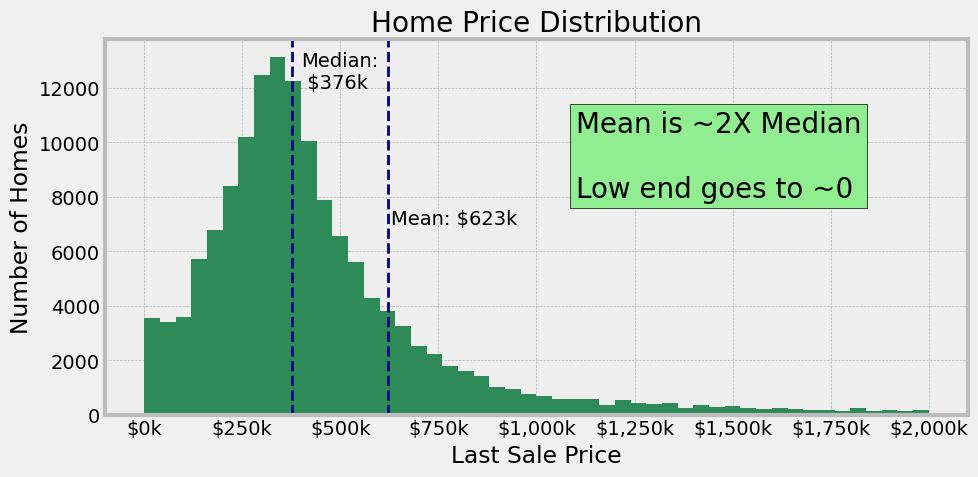

In [ ]:
plt.figure(figsize=(10,5))
plt.style.use(style='bmh')

plt.hist(data['lastSalePrice'], bins=50, range=(0,2_000_000), color='seagreen')

plt.xlabel('Last Sale Price')
plt.ylabel('Number of Homes')

ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x/1000:,.0f}k'))

plt.axvline(x=376000, color='darkblue', linestyle='--')
plt.annotate('Median:\n $376k', (400000,12000))

plt.axvline(x=622508, color='darkblue', linestyle='--')
plt.annotate('Mean: $623k', (630000,7000))

plt.title('Home Price Distribution')

plt.text(1_100_000, 8000, 'Mean is ~2X Median\n\nLow end goes to ~0', bbox=dict(facecolor='lightgreen', edgecolor='black'), fontsize=20)

plt.tight_layout()
# plt.savefig('price_distribution.png')
plt.show()

In [28]:
data.describe()

,zipCode,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,hoa,cooling,heating,fireplace,floorCount,garage,garageSpaces,roomCount,unitCount
count,"145,617.00","145,617.00","145,617.00","126,303.00","127,999.00","130,281.00","128,260.00","127,154.00","145,533.00","10,993.00","145,617.00","145,617.00","145,617.00","92,934.00","145,617.00","18,767.00","10,703.00","96,266.00"
mean,"33,468.92",27.86,-81.70,2.99,2.18,"1,723.46","46,127.96","1,990.28","622,508.48",363.07,0.55,0.51,0.10,1.23,0.50,1.71,5.51,1.19
std,800.99,1.37,1.32,3.41,3.33,"1,793.94","2,517,346.51",24.46,"2,339,231.39",377.36,0.50,0.50,0.30,0.75,0.50,1.06,14.54,25.37
min,"32,003.00",24.55,-87.51,0.00,0.50,1.00,1.00,202.00,300.00,5.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00
25%,"32,832.00",26.64,-82.33,2.00,2.00,"1,200.00","5,663.00","1,974.00","260,000.00",72.00,0.00,0.00,0.00,1.00,0.00,1.00,4.00,1.00
50%,"33,510.00",27.94,-81.67,3.00,2.00,"1,578.00","8,015.00","1,990.00","376,000.00",265.00,1.00,1.00,0.00,1.00,1.00,2.00,5.00,1.00
75%,"33,993.00",28.67,-80.65,3.00,2.00,"2,020.00","11,195.00","2,008.00","555,000.00",525.00,1.00,1.00,0.00,1.00,1.00,2.00,6.00,1.00
max,"34,997.00",30.99,-80.03,720.00,600.00,"387,389.00","600,000,000.00","2,028.00","345,000,000.00","2,500.00",1.00,1.00,1.00,33.00,1.00,114.00,"1,248.00","5,760.00"


In [29]:
singlefam_condo = data[data['propertyType'].isin(['Single Family', 'Condo'])]
singlefam_condo.describe()

,zipCode,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,hoa,cooling,heating,fireplace,floorCount,garage,garageSpaces,roomCount,unitCount
count,"122,532.00","122,532.00","122,532.00","113,314.00","114,619.00","116,691.00","109,071.00","114,430.00","122,516.00","9,079.00","122,532.00","122,532.00","122,532.00","86,744.00","122,532.00","17,960.00","9,858.00","89,924.00"
mean,"33,442.34",27.86,-81.68,2.97,2.16,"1,727.50","47,241.29","1,989.70","563,912.70",379.52,0.61,0.56,0.11,1.23,0.57,1.72,5.37,1.05
std,797.31,1.39,1.33,1.09,2.69,"1,291.47","2,656,473.11",24.09,"1,859,445.91",394.65,0.49,0.50,0.31,0.77,0.50,1.07,7.23,6.21
min,"32,003.00",24.55,-87.51,0.00,0.50,1.00,1.00,202.00,300.00,5.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00
25%,"32,824.00",26.61,-82.33,2.00,2.00,"1,208.00","5,775.00","1,973.00","270,000.00",70.00,0.00,0.00,0.00,1.00,0.00,1.00,4.00,1.00
50%,"33,462.00",27.94,-81.65,3.00,2.00,"1,584.00","8,154.00","1,990.00","380,000.00",283.00,1.00,1.00,0.00,1.00,1.00,2.00,5.00,1.00
75%,"33,980.00",28.69,-80.46,3.00,2.00,"2,031.00","11,237.00","2,007.00","555,000.00",550.00,1.00,1.00,0.00,1.00,1.00,2.00,6.00,1.00
max,"34,997.00",30.98,-80.03,176.00,300.00,"277,454.00","600,000,000.00","2,028.00","345,000,000.00","2,500.00",1.00,1.00,1.00,33.00,1.00,114.00,700.00,"1,674.00"


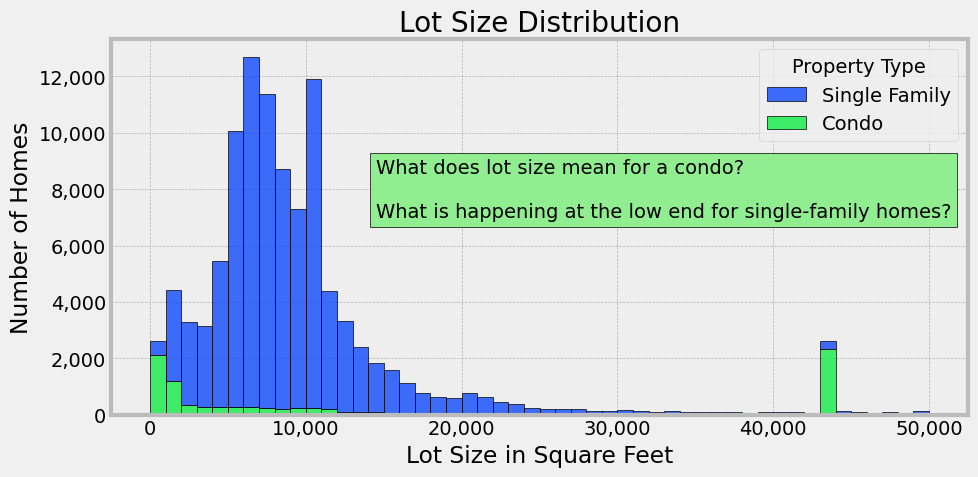

In [ ]:
plt.figure(figsize=(10,5))
plt.style.use(style='seaborn-v0_8-bright')

plot = sns.histplot(data=singlefam_condo, x='lotSize',  bins=50, hue='propertyType', multiple='stack', binrange=(0, 50_000), edgecolor='black')

ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel('Lot Size in Square Feet')
plt.ylabel('Number of Homes')

plt.text(14_500, 7_000, 'What does lot size mean for a condo?\n\nWhat is happening at the low end for single-family homes?', bbox=dict(facecolor='lightgreen', edgecolor='black'))

plot.legend_.set_title('Property Type')

plt.title('Lot Size Distribution')

plt.tight_layout()
# plt.savefig('lot_size_distribution.png')
plt.show()

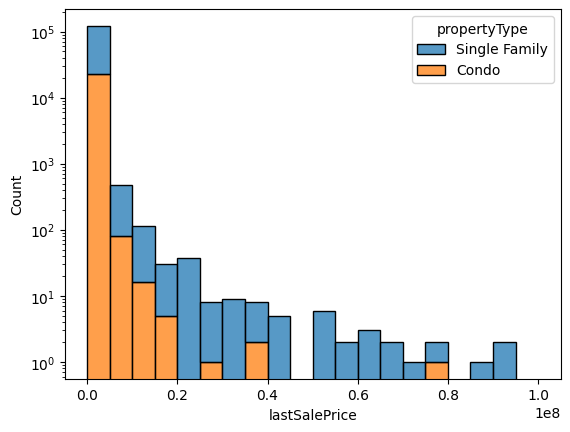

In [ ]:
sns.histplot(data=singlefam_condo, x='lastSalePrice',  bins=20, hue='propertyType', multiple='stack', binrange=(0,100_000_000))
plt.yscale('log')
plt.show()

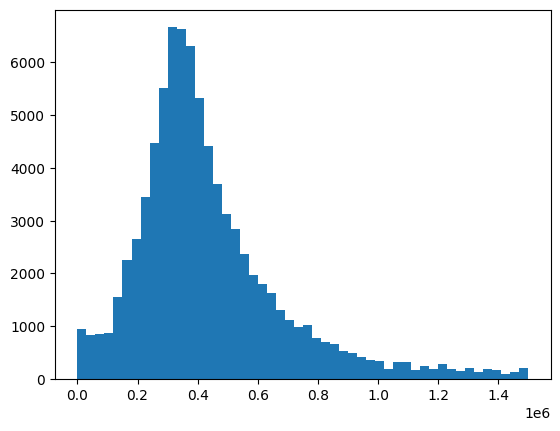

In [ ]:
newer = data[data['yearBuilt'] >= 1980]

plt.hist(newer['lastSalePrice'], bins=50, range=(0, 1_000_000))
plt.show()

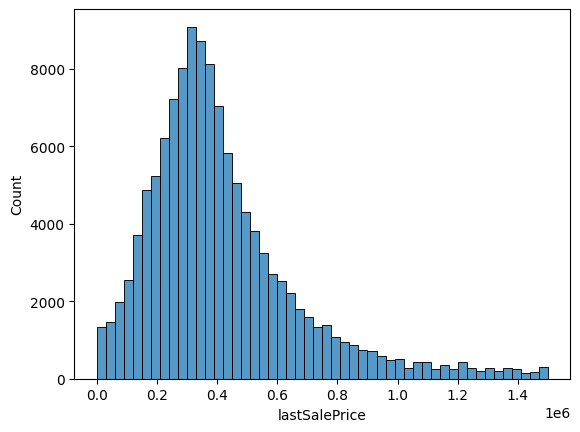

In [ ]:
newer = data[data['yearBuilt'] >= 0]

sns.histplot(data=newer, x='lastSalePrice', bins=50, binrange=(0, 1_500_000))
plt.show()

In [ ]:
# Confirming no duplicates (dropped before converting original csv to database)

data.duplicated().any()

np.False_

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145617 entries, 0 to 145616
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                145617 non-null  object 
 1   formattedAddress  145617 non-null  object 
 2   city              145617 non-null  object 
 3   state             145617 non-null  object 
 4   zipCode           145617 non-null  int64  
 5   county            145495 non-null  object 
 6   latitude          145617 non-null  float64
 7   longitude         145617 non-null  float64
 8   propertyType      143304 non-null  object 
 9   bedrooms          126303 non-null  float64
 10  bathrooms         127999 non-null  float64
 11  squareFootage     130281 non-null  float64
 12  lotSize           128260 non-null  float64
 13  yearBuilt         127154 non-null  float64
 14  subdivision       117944 non-null  object 
 15  zoning            86564 non-null   object 
 16  lastSaleDate      14

In [ ]:
# Creating years old column to use in model instead of yearBuilt

data['years_old'] = 2025 - data['yearBuilt']

In [ ]:
# Converting zip code to string

data['zipCode'] = data['zipCode'].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145617 entries, 0 to 145616
Data columns (total 36 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                145617 non-null  object 
 1   formattedAddress  145617 non-null  object 
 2   city              145617 non-null  object 
 3   state             145617 non-null  object 
 4   zipCode           145617 non-null  object 
 5   county            145495 non-null  object 
 6   latitude          145617 non-null  float64
 7   longitude         145617 non-null  float64
 8   propertyType      143304 non-null  object 
 9   bedrooms          126303 non-null  float64
 10  bathrooms         127999 non-null  float64
 11  squareFootage     130281 non-null  float64
 12  lotSize           128260 non-null  float64
 13  yearBuilt         127154 non-null  float64
 14  subdivision       117944 non-null  object 
 15  zoning            86564 non-null   object 
 16  lastSaleDate      14

In [ ]:
data.describe()

,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,hoa,cooling,heating,fireplace,floorCount,garage,garageSpaces,roomCount,unitCount,years_old
count,"145,617.00","145,617.00","126,303.00","127,999.00","130,281.00","128,260.00","127,154.00","145,533.00","10,993.00","145,617.00","145,617.00","145,617.00","92,934.00","145,617.00","18,767.00","10,703.00","96,266.00","127,154.00"
mean,27.86,-81.70,2.99,2.18,"1,723.46","46,127.96","1,990.28","622,508.48",363.07,0.55,0.51,0.10,1.23,0.50,1.71,5.51,1.19,34.72
std,1.37,1.32,3.41,3.33,"1,793.94","2,517,346.51",24.46,"2,339,231.39",377.36,0.50,0.50,0.30,0.75,0.50,1.06,14.54,25.37,24.46
min,24.55,-87.51,0.00,0.50,1.00,1.00,202.00,300.00,5.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,-3.00
25%,26.64,-82.33,2.00,2.00,"1,200.00","5,663.00","1,974.00","260,000.00",72.00,0.00,0.00,0.00,1.00,0.00,1.00,4.00,1.00,17.00
50%,27.94,-81.67,3.00,2.00,"1,578.00","8,015.00","1,990.00","376,000.00",265.00,1.00,1.00,0.00,1.00,1.00,2.00,5.00,1.00,35.00
75%,28.67,-80.65,3.00,2.00,"2,020.00","11,195.00","2,008.00","555,000.00",525.00,1.00,1.00,0.00,1.00,1.00,2.00,6.00,1.00,51.00
max,30.99,-80.03,720.00,600.00,"387,389.00","600,000,000.00","2,028.00","345,000,000.00","2,500.00",1.00,1.00,1.00,33.00,1.00,114.00,"1,248.00","5,760.00","1,823.00"


In [ ]:
# Creating column with average interest rates from FRED

data.lastSaleDate = pd.to_datetime(data.lastSaleDate)

data['year_month'] = data['lastSaleDate'].dt.to_period('M')

t_rate = {
    '2024-03':0.0421,
    '2024-04':0.0454,
    '2024-05':0.0448,
    '2024-06':0.0431,
    '2024-07':0.0425,
    '2024-08':0.0387,
    '2024-09':0.0372,
    '2024-10':0.041,
    '2024-11':0.0436,
    '2024-12':0.0439,
    '2025-01':0.0463,
    '2025-02':0.0445,
    '2025-03':0.0668
}

data['year_month'] = data['year_month'].dt.strftime('%Y-%m')

data['t_rate'] = data['year_month'].map(t_rate)


/tmp/ipykernel_6417/976391788.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = data['lastSaleDate'].dt.to_period('M')


In [ ]:
# Dropping columns with few values or that appear redundant/unnecessary

drop_cols = ['zoning','hoa','architectureType','coolingType','heatingType','garageSpaces','garageType','roomCount','foundationType','exteriorType'] 
# initially dropped viewType, but saving it for now because of later EDA concerns

data = data.drop(drop_cols, axis=1)
data.shape

(145617, 28)

In [ ]:
data['propertyType'].value_counts()

propertyType
Single Family    99845
Condo            22687
Land             12123
Manufactured      3834
Multi-Family      2417
Townhouse         1842
Apartment          556
Name: count, dtype: int64

In [ ]:
# Dropping Land category as outside the scope of the project

data = data[data['propertyType'] != 'Land']
data.shape

(133494, 28)

In [ ]:
# Very few apartments--investigating further

apt = data[data['propertyType'] == 'Apartment']
apt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 345 to 145394
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                556 non-null    object             
 1   formattedAddress  556 non-null    object             
 2   city              556 non-null    object             
 3   state             556 non-null    object             
 4   zipCode           556 non-null    object             
 5   county            555 non-null    object             
 6   latitude          556 non-null    float64            
 7   longitude         556 non-null    float64            
 8   propertyType      556 non-null    object             
 9   bedrooms          491 non-null    float64            
 10  bathrooms         517 non-null    float64            
 11  squareFootage     515 non-null    float64            
 12  lotSize           300 non-null    float64            
 13  yearB

In [ ]:
apt.describe()

,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,unitCount,years_old,t_rate
count,556.00,556.00,491.00,517.00,515.00,300.00,502.00,556.00,556.00,556.00,556.00,158.00,556.00,204.00,502.00,556.00
mean,27.03,-81.00,3.53,2.06,"2,336.46","726,228.12","1,974.31","4,220,089.09",0.20,0.18,0.01,1.26,0.12,7.14,50.69,0.04
std,1.35,1.15,32.53,6.27,"9,718.91","11,591,839.34",24.99,"15,229,785.82",0.40,0.38,0.12,0.63,0.32,37.59,24.99,0.00
min,24.66,-87.31,0.00,1.00,100.00,25.00,"1,700.00","5,000.00",0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.04
25%,25.97,-81.76,1.00,1.00,685.00,"6,299.50","1,962.00","225,000.00",0.00,0.00,0.00,1.00,0.00,1.00,40.00,0.04
50%,26.26,-80.31,2.00,1.00,928.00,"10,408.00","1,972.00","497,500.00",0.00,0.00,0.00,1.00,0.00,1.00,53.00,0.04
75%,28.05,-80.14,2.00,2.00,"1,374.00","23,522.00","1,985.00","1,360,000.00",0.00,0.00,0.00,1.00,0.00,1.00,63.00,0.04
max,30.43,-80.03,720.00,127.00,"178,877.00","200,811,600.00","2,024.00","139,250,000.00",1.00,1.00,1.00,5.00,1.00,352.00,325.00,0.05


In [ ]:
# Very large max and standard deviation values--this is probably a mixture of large buildings and single units (reasons for listing as apartment vs. condo unclear)
# Checking a few on Zillow

apt.head(10)

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate
345,"2200-E-Hallandale-Beach-Blvd,-Apt-211,-Halland...","2200 E Hallandale Beach Blvd, Apt 211, Halland...",Hallandale Beach,FL,33009,Broward,25.99,-80.13,Apartment,1.00,...,0,0,NaN,0,False,NaN,None,56.00,2024-03,0.04
1291,"11113-Airport-Dr,-Sebastian,-FL-32958","11113 Airport Dr, Sebastian, FL 32958",Sebastian,FL,32958,Indian River,27.80,-80.50,Apartment,4.00,...,1,0,1.00,0,False,2.00,None,38.00,2024-03,0.04
1338,"1809-Jackson-St,-Unit-623,-Hollywood,-FL-33020","1809 Jackson St, Unit 623, Hollywood, FL 33020",Hollywood,FL,33020,Broward,26.01,-80.14,Apartment,1.00,...,0,0,NaN,0,False,NaN,None,1.00,2024-03,0.04
1664,"10764-70th-Ave,-Unit-7305,-Seminole,-FL-33772","10764 70th Ave, Unit 7305, Seminole, FL 33772",Seminole,FL,33772,Pinellas,27.84,-82.79,Apartment,2.00,...,0,0,1.00,0,True,1.00,Average,27.00,2024-03,0.04
1872,"200-S-11th-St,-Ste-103,-Leesburg,-FL-34748","200 S 11th St, Ste 103, Leesburg, FL 34748",Leesburg,FL,34748,Lake,28.81,-81.88,Apartment,2.00,...,1,0,2.00,0,False,NaN,None,18.00,2024-03,0.04
1943,"6905-Rue-Vendome,-Apt-9,-Miami-Beach,-FL-33141","6905 Rue Vendome, Apt 9, Miami Beach, FL 33141",Miami Beach,FL,33141,Miami-Dade,25.85,-80.13,Apartment,1.00,...,0,0,NaN,0,False,NaN,None,67.00,2024-03,0.04
2705,"1514-Sw-6th-St,-Apt-4,-Miami,-FL-33135","1514 Sw 6th St, Apt 4, Miami, FL 33135",Miami,FL,33135,Miami-Dade,25.77,-80.22,Apartment,2.00,...,0,0,NaN,0,False,NaN,None,71.00,2024-03,0.04
3387,"900-Atlantic-Shores-Blvd,-Apt-107,-Hallandale-...","900 Atlantic Shores Blvd, Apt 107, Hallandale ...",Hallandale Beach,FL,33009,Broward,25.99,-80.14,Apartment,1.00,...,0,0,NaN,0,False,NaN,None,66.00,2024-03,0.04
3693,"3051-S-Palm-Aire-Dr,-Apt-201,-Pompano-Beach,-F...","3051 S Palm Aire Dr, Apt 201, Pompano Beach, F...",Pompano Beach,FL,33069,Broward,26.22,-80.16,Apartment,3.00,...,0,0,NaN,0,False,NaN,None,53.00,2024-03,0.04
4143,"805-81st-St,-Apt-1,-Miami-Beach,-FL-33141","805 81st St, Apt 1, Miami Beach, FL 33141",Miami Beach,FL,33141,Miami-Dade,25.87,-80.13,Apartment,1.00,...,0,0,NaN,0,False,NaN,None,73.00,2024-03,0.04


In [ ]:
# These few values are inconsistent in terms of what they are--some are condos, some are rentals, others are unclear. Dropping this category.

data = data[data['propertyType'] != 'Apartment']
data.shape

(132938, 28)

In [ ]:
# Investigating nulls in bedroom and bathroom for condos

data[(data['bedrooms'].isna()) & (data['propertyType'] == 'Condo')]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate
11,"4250-Biscayne-Blvd,-Apt-510,-Miami,-FL-33137","4250 Biscayne Blvd, Apt 510, Miami, FL 33137",Miami,FL,33137,Miami-Dade,25.82,-80.19,Condo,NaN,...,0,0,NaN,0,False,NaN,None,10.00,2024-03,0.04
255,"1621-Gulf-Blvd,-Apt-705,-Clearwater-Beach,-FL-...","1621 Gulf Blvd, Apt 705, Clearwater Beach, FL ...",Clearwater Beach,FL,33767,Pinellas,27.94,-82.84,Condo,NaN,...,1,0,1.00,1,True,1.00,Water,51.00,2024-03,0.04
320,"505-Mandalay-Ave,-Apt-66,-Clearwater-Beach,-FL...","505 Mandalay Ave, Apt 66, Clearwater Beach, FL...",Clearwater Beach,FL,33767,Pinellas,27.98,-82.82,Condo,NaN,...,0,0,3.00,1,True,1.00,None,20.00,2024-03,0.04
465,"999-Fort-Pickens-Rd,-Apt-501,-Gulf-Breeze,-FL-...","999 Fort Pickens Rd, Apt 501, Gulf Breeze, FL ...",Gulf Breeze,FL,32561,Escambia,30.33,-87.16,Condo,NaN,...,1,0,1.00,0,False,1.00,None,50.00,2024-03,0.04
577,"2900-45th-St-S,-Apt-1,-Gulfport,-FL-33711","2900 45th St S, Apt 1, Gulfport, FL 33711",Gulfport,FL,33711,Pinellas,27.74,-82.69,Condo,NaN,...,1,0,1.00,0,True,1.00,Water,62.00,2024-03,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145333,"6500-Valen-Way,-Apt-301,-Naples,-FL-34108","6500 Valen Way, Apt 301, Naples, FL 34108",Naples,FL,34108,Collier,26.23,-81.81,Condo,NaN,...,0,0,NaN,0,False,NaN,None,35.00,2024-06,0.04
145338,"9138-Chula-Vista-St,-Unit-12702,-Naples,-FL-34113","9138 Chula Vista St, Unit 12702, Naples, FL 34113",Naples,FL,34113,Collier,26.07,-81.69,Condo,NaN,...,0,0,NaN,0,False,NaN,None,18.00,2024-06,0.04
145440,"414-School-Rd,-Apt-96,-Indian-Harbour-Beach,-F...","414 School Rd, Apt 96, Indian Harbour Beach, F...",Indian Harbour Beach,FL,32937,Brevard,28.15,-80.59,Condo,NaN,...,1,0,NaN,0,False,1.00,None,48.00,2024-06,0.04
145487,"4084-Northlight-Dr,-Naples,-FL-34112","4084 Northlight Dr, Naples, FL 34112",Naples,FL,34112,Collier,26.14,-81.76,Condo,NaN,...,0,0,NaN,0,False,1.00,None,38.00,2024-06,0.04


In [ ]:
# I suspected condos with null for bedrooms would be studio apartments, but checking these on Zillow shows no pattern.

In [ ]:
data[(data['bedrooms'].isna()) & (data['bathrooms'].isna())]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate
86,"7101-Carmel-Dr,-Tallahassee,-FL-32309","7101 Carmel Dr, Tallahassee, FL 32309",Tallahassee,FL,32309,Leon,30.55,-84.19,Single Family,NaN,...,0,0,1.00,1,False,1.00,None,43.00,2024-03,0.04
175,"971-Mendel-Ave,-Marco-Island,-FL-34145","971 Mendel Ave, Marco Island, FL 34145",Marco Island,FL,34145,Collier,25.92,-81.72,Single Family,NaN,...,0,0,1.00,0,True,1.00,None,47.00,2024-03,0.04
196,"110-Nw-53rd-St,-Deerfield-Beach,-FL-33064","110 Nw 53rd St, Deerfield Beach, FL 33064",Deerfield Beach,FL,33064,Broward,26.29,-80.12,Manufactured,NaN,...,0,0,1.00,0,False,1.00,None,50.00,2024-03,0.04
197,"222-Nw-54th-St,-Deerfield-Beach,-FL-33064","222 Nw 54th St, Deerfield Beach, FL 33064",Deerfield Beach,FL,33064,Broward,26.30,-80.13,Manufactured,NaN,...,0,0,1.00,0,False,1.00,None,44.00,2024-03,0.04
234,"1507-Redondo-Way,-Lady-Lake,-FL-32159","1507 Redondo Way, Lady Lake, FL 32159",Lady Lake,FL,32159,Sumter,28.93,-81.96,Single Family,NaN,...,0,0,NaN,1,False,1.00,None,28.00,2024-03,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145521,"2950-Glades-Cir,-Ste-13,-Weston,-FL-33327","2950 Glades Cir, Ste 13, Weston, FL 33327",Weston,FL,33327,Broward,26.14,-80.42,None,NaN,...,0,0,NaN,0,False,NaN,None,NaN,2024-06,0.04
145533,"1333-E-Main-St,-Lakeland,-FL-33801","1333 E Main St, Lakeland, FL 33801",Lakeland,FL,33801,Polk,28.04,-81.94,None,NaN,...,0,0,NaN,0,False,NaN,None,NaN,2024-06,0.04
145560,"520-Whitney-Ave,-Ste-B3,-Lantana,-FL-33462","520 Whitney Ave, Ste B3, Lantana, FL 33462",Lantana,FL,33462,Palm Beach,26.59,-80.06,None,NaN,...,0,0,NaN,0,False,NaN,None,NaN,2024-06,0.04
145571,"624-Monroe-Ave,-Apt-401,-Cape-Canaveral,-FL-32920","624 Monroe Ave, Apt 401, Cape Canaveral, FL 32920",Cape Canaveral,FL,32920,Brevard,28.39,-80.60,Condo,NaN,...,0,0,NaN,0,False,1.00,None,20.00,2024-06,0.04


In [ ]:
# Dropping rows with nulls for bedrooms, bathrooms, or propertyType--no apparent pattern from Zillow checks

data = data.dropna(subset=['bedrooms','bathrooms','propertyType'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120766 entries, 0 to 145616
Data columns (total 28 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                120766 non-null  object             
 1   formattedAddress  120766 non-null  object             
 2   city              120766 non-null  object             
 3   state             120766 non-null  object             
 4   zipCode           120766 non-null  object             
 5   county            120697 non-null  object             
 6   latitude          120766 non-null  float64            
 7   longitude         120766 non-null  float64            
 8   propertyType      120766 non-null  object             
 9   bedrooms          120766 non-null  float64            
 10  bathrooms         120766 non-null  float64            
 11  squareFootage     120553 non-null  float64            
 12  lotSize           108182 non-null  float64       

In [ ]:
# Investigating properties with nulls for square footage

data[data['squareFootage'].isna()]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate
2553,"4300-Sw-194th-Ave,-Ocala,-FL-34432","4300 Sw 194th Ave, Ocala, FL 34432",Ocala,FL,34432,Marion,29.15,-82.44,Manufactured,2.00,...,0,0,NaN,0,False,NaN,None,38.00,2024-03,0.04
2680,"2019-Detroit-Dr,-Unit-2019,-Labelle,-FL-33935","2019 Detroit Dr, Unit 2019, Labelle, FL 33935",Labelle,FL,33935,Hendry,26.75,-81.41,Single Family,3.00,...,0,0,NaN,0,False,NaN,None,NaN,2024-03,0.04
7091,"2285-Se-7th-St,-Pompano-Beach,-FL-33062","2285 Se 7th St, Pompano Beach, FL 33062",Pompano Beach,FL,33062,Broward,26.23,-80.10,Single Family,3.00,...,0,0,NaN,0,False,NaN,None,2.00,2024-03,0.04
8408,"7300-Sw-173rd-St,-Palmetto-Bay,-FL-33157","7300 Sw 173rd St, Palmetto Bay, FL 33157",Palmetto Bay,FL,33157,Miami-Dade,25.61,-80.31,Single Family,5.00,...,0,0,NaN,0,False,NaN,None,3.00,2024-03,0.04
8507,"348-Honeycomb-Trl,-Saint-Augustine,-FL-32095","348 Honeycomb Trl, Saint Augustine, FL 32095",Saint Augustine,FL,32095,Saint Johns,29.98,-81.36,Single Family,4.00,...,0,0,1.00,1,False,NaN,None,1.00,2024-03,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141729,"29265-Sw-163rd-Ct,-Homestead,-FL-33033","29265 Sw 163rd Ct, Homestead, FL 33033",Homestead,FL,33033,Miami-Dade,25.49,-80.45,Single Family,3.00,...,0,0,NaN,0,False,NaN,None,1.00,2024-06,0.04
142989,"737-Lightsey-Crossing-Ln,-Saint-Augustine,-FL-...","737 Lightsey Crossing Ln, Saint Augustine, FL ...",Saint Augustine,FL,32084,Saint Johns,29.86,-81.37,Single Family,4.00,...,0,0,NaN,0,False,NaN,None,1.00,2024-06,0.04
144050,"3908-Southern-Vista-Loop,-Saint-Cloud,-FL-34772","3908 Southern Vista Loop, Saint Cloud, FL 34772",Saint Cloud,FL,34772,Osceola,28.22,-81.27,Single Family,4.00,...,0,0,NaN,0,False,NaN,None,1.00,2024-06,0.04
144271,"630-Lightsey-Crossing-Ln,-Saint-Augustine,-FL-...","630 Lightsey Crossing Ln, Saint Augustine, FL ...",Saint Augustine,FL,32084,Saint Johns,29.86,-81.37,Single Family,4.00,...,0,0,NaN,0,False,NaN,None,1.00,2024-06,0.04


In [ ]:
# No pattern--dropping these rows
data = data.dropna(subset=['squareFootage'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120553 entries, 0 to 145616
Data columns (total 28 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                120553 non-null  object             
 1   formattedAddress  120553 non-null  object             
 2   city              120553 non-null  object             
 3   state             120553 non-null  object             
 4   zipCode           120553 non-null  object             
 5   county            120487 non-null  object             
 6   latitude          120553 non-null  float64            
 7   longitude         120553 non-null  float64            
 8   propertyType      120553 non-null  object             
 9   bedrooms          120553 non-null  float64            
 10  bathrooms         120553 non-null  float64            
 11  squareFootage     120553 non-null  float64            
 12  lotSize           108051 non-null  float64       

In [ ]:
# Nulls for yearBuilt

data[data['yearBuilt'].isna()]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate
409,"2704-Ne-7th-Pl,-Cape-Coral,-FL-33909","2704 Ne 7th Pl, Cape Coral, FL 33909",Cape Coral,FL,33909,Lee,26.70,-81.96,Single Family,4.00,...,0,0,NaN,0,False,NaN,None,NaN,2024-03,0.04
451,"24-Palermo-Ln,-Palm-Coast,-FL-32164","24 Palermo Ln, Palm Coast, FL 32164",Palm Coast,FL,32164,Flagler,29.54,-81.22,Single Family,4.00,...,0,0,NaN,0,False,NaN,None,NaN,2024-03,0.04
461,"3623-Woodmont-Dr,-Parrish,-FL-34219","3623 Woodmont Dr, Parrish, FL 34219",Parrish,FL,34219,Manatee,27.55,-82.46,Single Family,3.00,...,0,0,NaN,0,False,NaN,None,NaN,2024-03,0.04
550,"4129-Acoma-Dr,-Ormond-Beach,-FL-32174","4129 Acoma Dr, Ormond Beach, FL 32174",Ormond Beach,FL,32174,Volusia,29.41,-81.15,Condo,5.00,...,0,0,NaN,0,False,NaN,None,NaN,2024-03,0.04
981,"12233-Sw-Nettuno-Way,-Port-Saint-Lucie,-FL-34987","12233 Sw Nettuno Way, Port Saint Lucie, FL 34987",Port Saint Lucie,FL,34987,Saint Lucie,27.29,-80.45,Single Family,4.00,...,0,0,NaN,0,False,NaN,None,NaN,2024-03,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145597,"38120-Shale-Stone-Ct,-Zephyrhills,-FL-33540","38120 Shale Stone Ct, Zephyrhills, FL 33540",Zephyrhills,FL,33540,Pasco,28.20,-82.19,Single Family,5.00,...,0,0,NaN,0,False,NaN,None,NaN,2024-06,0.04
145599,"1315-Nw-132nd-Cir,-Newberry,-FL-32669","1315 Nw 132nd Cir, Newberry, FL 32669",Newberry,FL,32669,Alachua,29.67,-82.48,Single Family,3.00,...,0,0,NaN,0,False,NaN,None,NaN,2024-06,0.04
145600,"111-Charmer-Trce,-Saint-Augustine,-FL-32092","111 Charmer Trce, Saint Augustine, FL 32092",Saint Augustine,FL,32092,Saint Johns,29.92,-81.52,Single Family,3.00,...,0,0,NaN,0,False,NaN,None,NaN,2024-06,0.04
145613,"249-Seaforth-Dr,-Saint-Augustine,-FL-32092","249 Seaforth Dr, Saint Augustine, FL 32092",Saint Augustine,FL,32092,Saint Johns,30.02,-81.57,Single Family,4.00,...,0,0,NaN,0,False,NaN,None,NaN,2024-06,0.04


In [ ]:
# This subset of nulls for yearBuilt all appear to be new builds--filling this with 2024

data['yearBuilt'] = data['yearBuilt'].fillna(2024)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120553 entries, 0 to 145616
Data columns (total 28 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                120553 non-null  object             
 1   formattedAddress  120553 non-null  object             
 2   city              120553 non-null  object             
 3   state             120553 non-null  object             
 4   zipCode           120553 non-null  object             
 5   county            120487 non-null  object             
 6   latitude          120553 non-null  float64            
 7   longitude         120553 non-null  float64            
 8   propertyType      120553 non-null  object             
 9   bedrooms          120553 non-null  float64            
 10  bathrooms         120553 non-null  float64            
 11  squareFootage     120553 non-null  float64            
 12  lotSize           108051 non-null  float64       

In [ ]:
# Nulls for lotSize

data[data['lotSize'].isna()].head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate
14,"94-Upminster-D,-Deerfield-Beach,-FL-33442","94 Upminster D, Deerfield Beach, FL 33442",Deerfield Beach,FL,33442,Broward,26.31,-80.13,Condo,2.00,...,0,0,NaN,0,False,1.00,None,49.00,2024-03,0.04
24,"1300-S-Miami-Ave,-Unit-1508,-Miami,-FL-33130","1300 S Miami Ave, Unit 1508, Miami, FL 33130",Miami,FL,33130,Miami-Dade,25.76,-80.19,Condo,1.00,...,0,0,NaN,0,False,NaN,None,9.00,2024-03,0.04
46,"7240-Nw-114th-Ave,-Apt-102,-Doral,-FL-33178","7240 Nw 114th Ave, Apt 102, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.84,-80.38,Condo,1.00,...,0,0,NaN,0,False,1.00,None,22.00,2024-03,0.04
59,"2908-Se-17th-Ave,-Unit-101,-Homestead,-FL-33035","2908 Se 17th Ave, Unit 101, Homestead, FL 33035",Homestead,FL,33035,Miami-Dade,25.44,-80.45,Condo,3.00,...,0,0,1.00,0,False,NaN,None,19.00,2024-03,0.04
70,"3000-S-Ocean-Dr,-Apt-1200,-Hollywood,-FL-33019","3000 S Ocean Dr, Apt 1200, Hollywood, FL 33019",Hollywood,FL,33019,Broward,25.99,-80.12,Condo,2.00,...,0,0,NaN,0,False,1.00,None,55.00,2024-03,0.04


In [ ]:
# Checking how many with null lot size are condos

data[(data['lotSize'].isna()) & (data['propertyType'] == 'Condo')].count()

id                  10492
formattedAddress    10492
city                10492
state               10492
zipCode             10492
county              10486
latitude            10492
longitude           10492
propertyType        10492
bedrooms            10492
bathrooms           10492
squareFootage       10492
lotSize                 0
yearBuilt           10492
subdivision          9118
lastSaleDate        10492
lastSalePrice       10491
cooling             10492
heating             10492
fireplace           10492
floorCount           2040
garage              10492
pool                10492
unitCount            7316
viewType             1070
years_old           10444
year_month          10492
t_rate              10492
dtype: int64

In [ ]:
# Filling nulls in lotSize for condos with 0

data.loc[(data['propertyType'] == 'Condo') & (data['lotSize'].isnull()), 'lotSize'] = 0


In [ ]:
# Filling nulls in floor count with 1

data['floorCount'] = data['floorCount'].fillna(1)
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 120553 entries, 0 to 145616
Data columns (total 28 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                120553 non-null  object             
 1   formattedAddress  120553 non-null  object             
 2   city              120553 non-null  object             
 3   state             120553 non-null  object             
 4   zipCode           120553 non-null  object             
 5   county            120487 non-null  object             
 6   latitude          120553 non-null  float64            
 7   longitude         120553 non-null  float64            
 8   propertyType      120553 non-null  object             
 9   bedrooms          120553 non-null  float64            
 10  bathrooms         120553 non-null  float64            
 11  squareFootage     120553 non-null  float64            
 12  lotSize           118543 non-null  float64       

In [ ]:
# Dropping nulls for lastSalePrice

data = data.dropna(subset=['lastSalePrice'])

# more EDA on lotSize

In [ ]:
# Investigating the remaining lot size column with condos

condo_lots = data[data['propertyType'] == 'Condo']['lotSize']
condo_lots.head()

3       951.00
4    43,560.00
14        0.00
18   43,560.00
21    8,132.00
Name: lotSize, dtype: float64

In [ ]:
condo_lots.describe()

count       21,213.00
mean        94,194.82
std      1,156,150.93
min              0.00
25%              0.00
50%            115.00
75%         11,903.00
max     99,999,995.00
Name: lotSize, dtype: float64

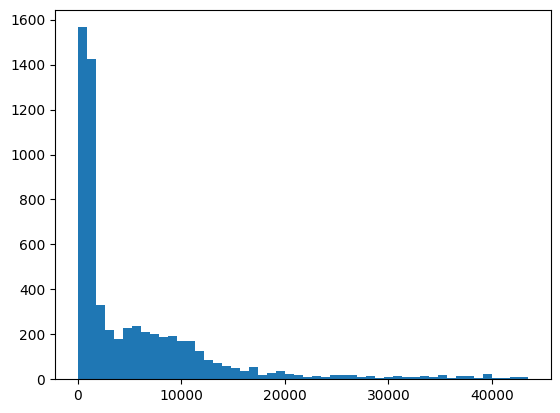

In [ ]:
# Histogram of listed lot sizes with upper quartile as upper range

plt.hist(condo_lots.dropna(), bins=50, range=(1,43500))
plt.show()

In [ ]:
# Looking at upper outliers

condos = data[data['propertyType'] == 'Condo']

condos[condos['lotSize'] >= 10000000.0].head(10)


,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate
625,"3628-Muirfield-Ct,-New-Port-Richey,-FL-34655","3628 Muirfield Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.21,-82.66,Condo,2.00,...,1,0,1.00,1,False,1.00,None,33.00,2024-03,0.04
15216,"3445-Niblick-Ct,-New-Port-Richey,-FL-34655","3445 Niblick Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.21,-82.66,Condo,2.00,...,1,0,1.00,1,False,1.00,None,39.00,2024-03,0.04
20123,"5973-Terrace-Park-Dr-N,-Unit-209,-Saint-Peters...","5973 Terrace Park Dr N, Unit 209, Saint Peters...",Saint Petersburg,FL,33709,Pinellas,27.83,-82.75,Condo,2.00,...,1,0,1.00,1,False,1.00,Average,45.00,2024-04,0.05
29161,"3734-River-Oaks-Ct,-New-Port-Richey,-FL-34655","3734 River Oaks Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.21,-82.67,Condo,2.00,...,1,0,1.00,1,False,1.00,None,41.00,2024-04,0.05
32126,"271-Sapphire-Lake-Dr,-Unit-101,-Bradenton,-FL-...","271 Sapphire Lake Dr, Unit 101, Bradenton, FL ...",Bradenton,FL,34209,Manatee,27.50,-82.68,Condo,3.00,...,1,0,1.00,1,False,1.00,None,12.00,2024-04,0.05
38623,"3654-Trophy-Blvd,-New-Port-Richey,-FL-34655","3654 Trophy Blvd, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.21,-82.66,Condo,2.00,...,1,0,1.00,1,0,1.00,None,51.00,2024-04,0.05
39517,"9617-Midiron-Ct,-New-Port-Richey,-FL-34655","9617 Midiron Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.21,-82.66,Condo,2.00,...,1,0,1.00,1,0,1.00,None,47.00,2024-04,0.05
42694,"3650-Trophy-Blvd,-New-Port-Richey,-FL-34655","3650 Trophy Blvd, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.21,-82.66,Condo,2.00,...,1,0,1.00,1,0,1.00,None,51.00,2024-04,0.05
47683,"3444-Teeside-Dr,-New-Port-Richey,-FL-34655","3444 Teeside Dr, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.21,-82.65,Condo,2.00,...,1,0,1.00,1,0,1.00,None,45.00,2024-04,0.05
60341,"3523-Teeside-Dr,-New-Port-Richey,-FL-34655","3523 Teeside Dr, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.21,-82.65,Condo,2.00,...,1,0,1.00,1,False,1.00,None,44.00,2024-05,0.04


Many of these condos with large lot sizes appear to have attached golf courses, but golf course is not stated in viewType (there are a number of different ways to indicate golf course in that column). 

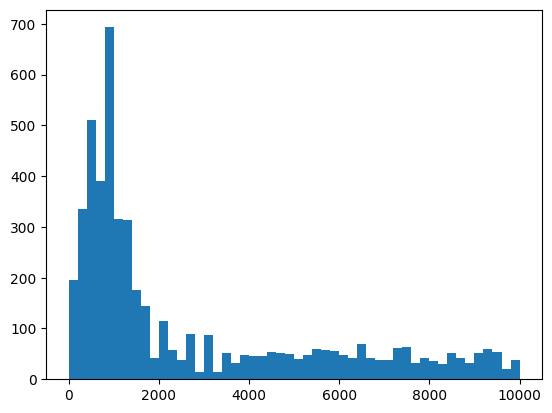

In [ ]:
# Looking at lower range--under 10,000

plt.hist(condo_lots.dropna(), bins=50, range=(1,10000))
plt.show()

In [ ]:
len(condos[condos['lotSize'] < 10000])

15532

In [ ]:
condos[condos['lotSize'] == 1].head(10)

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate
13581,"8247-Nw-108th-Ct,-Unit-2,-Doral,-FL-33178","8247 Nw 108th Ct, Unit 2, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.85,-80.37,Condo,3.00,...,0,0,2.00,0,False,NaN,None,19.00,2024-03,0.04
16593,"8432-Nw-107th-Ct,-Unit-11,-Doral,-FL-33178","8432 Nw 107th Ct, Unit 11, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.85,-80.37,Condo,4.00,...,0,0,2.00,0,False,NaN,None,20.00,2024-03,0.04
34603,"607-Verrocchio-Dr,-Nokomis,-FL-34275","607 Verrocchio Dr, Nokomis, FL 34275",Nokomis,FL,34275,Sarasota,27.17,-82.47,Condo,2.00,...,1,0,1.00,1,0,1.00,Water,23.00,2024-04,0.05
41854,"523-Pine-Hollow-Cir,-Englewood,-FL-34223","523 Pine Hollow Cir, Englewood, FL 34223",Englewood,FL,34223,Sarasota,26.96,-82.35,Condo,2.00,...,1,0,1.00,1,0,1.00,Lake,29.00,2024-04,0.05
42018,"1600-Sw-1st-Ave,-Apt-706,-Miami,-FL-33129","1600 Sw 1st Ave, Apt 706, Miami, FL 33129",Miami,FL,33129,Miami-Dade,25.76,-80.20,Condo,1.00,...,0,0,1.00,0,0,NaN,None,9.00,2024-04,0.05
43684,"10775-Nw-83rd-Ter,-Unit-1,-Doral,-FL-33178","10775 Nw 83rd Ter, Unit 1, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.85,-80.37,Condo,4.00,...,0,0,2.00,0,0,NaN,None,20.00,2024-04,0.05
46242,"1100-S-Miami-Ave,-Apt-3904,-Miami,-FL-33130","1100 S Miami Ave, Apt 3904, Miami, FL 33130",Miami,FL,33130,Miami-Dade,25.76,-80.19,Condo,2.00,...,0,0,1.00,0,0,NaN,None,10.00,2024-04,0.05
46549,"18555-Collins-Ave,-Apt-5505,-Sunny-Isles-Beach...","18555 Collins Ave, Apt 5505, Sunny Isles Beach...",Sunny Isles Beach,FL,33160,Miami-Dade,25.95,-80.12,Condo,3.00,...,0,0,1.00,0,0,NaN,None,9.00,2024-04,0.05
54145,"8244-Nw-107th-Path,-Unit-10,-Doral,-FL-33178","8244 Nw 107th Path, Unit 10, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.85,-80.37,Condo,2.00,...,0,0,2.00,0,False,NaN,None,20.00,2024-05,0.04
69451,"8501-Nw-107th-Ct,-Unit-3,-Doral,-FL-33178","8501 Nw 107th Ct, Unit 3, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.85,-80.37,Condo,2.00,...,0,0,2.00,0,False,NaN,None,20.00,2024-05,0.04


Dealing with lot size for condos--initial idea:
- With viewType column, simplify all titles with golf in the name to one value
- Search the subdivision column for the word golf and use it to alter the viewType column
- Drop large lot size values that don't have the word golf
- For properties without golf, assign the mean of the lower quartile to all lot sizes

In [ ]:
data['viewType'].value_counts()

viewType
Water                                              2423
Average                                            1622
Golf Course                                         590
Lake                                                286
Park                                                138
River                                                81
Lake / Pond                                          34
Canal                                                16
City                                                 15
Creek / Lake                                          9
Lake, Corner                                          9
Waterfront / Beach, Corner                            8
Fairway                                               8
Golf Course, Lake                                     7
Golf Course, Corner                                   6
Waterfront / Canal, Corner                            3
Historical                                            3
Waterfront / Beachfront (Ocean, River, 

In [ ]:
# Creating a binary golf column

golf_mapper = {
    'Golf Course':1,
    'Golf Course, Lake':1,
    'Golf Course, Corner':1,
    'Golf Course, Waterfront / Beach':1,
    'Lake, Golf Course':1
}

data['golf'] = data['viewType'].map(golf_mapper).fillna(0).astype(int)

In [ ]:
data['golf'].value_counts()

golf
0    119928
1       605
Name: count, dtype: int64

In [ ]:
data[data['subdivision'].str.contains('GOLF', case=False, na=False)]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate,golf
142,"210-Hazard-St,-Orlando,-FL-32804","210 Hazard St, Orlando, FL 32804",Orlando,FL,32804,Orange,28.59,-81.38,Single Family,2.00,...,0,1.00,1,False,1.00,None,70.00,2024-03,0.04,0
204,"5820-Nw-12th-St,-Apt-D,-Sunrise,-FL-33313","5820 Nw 12th St, Apt D, Sunrise, FL 33313",Sunrise,FL,33313,Broward,26.14,-80.23,Single Family,3.00,...,0,1.00,0,False,1.00,None,64.00,2024-03,0.04,0
207,"6680-Nw-29th-Ct,-Sunrise,-FL-33313","6680 Nw 29th Ct, Sunrise, FL 33313",Sunrise,FL,33313,Broward,26.16,-80.24,Single Family,2.00,...,0,1.00,1,False,1.00,None,57.00,2024-03,0.04,0
232,"8608-Se-141st-Street-Rd,-Summerfield,-FL-34491","8608 Se 141st Street Rd, Summerfield, FL 34491",Summerfield,FL,34491,Marion,29.02,-82.01,Single Family,2.00,...,0,1.00,1,False,1.00,None,28.00,2024-03,0.04,0
242,"3189-Pebble-Beach-Dr,-Lake-Worth,-FL-33467","3189 Pebble Beach Dr, Lake Worth, FL 33467",Lake Worth,FL,33467,Palm Beach,26.63,-80.17,Single Family,3.00,...,0,1.00,0,True,1.00,None,54.00,2024-03,0.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144783,"350-Club-Cir,-Apt-207,-Boca-Raton,-FL-33487","350 Club Cir, Apt 207, Boca Raton, FL 33487",Boca Raton,FL,33487,Palm Beach,26.40,-80.09,Condo,2.00,...,0,1.00,0,False,1.00,None,39.00,2024-06,0.04,0
144899,"836-Blue-Crane-Dr,-Venice,-FL-34285","836 Blue Crane Dr, Venice, FL 34285",Venice,FL,34285,Sarasota,27.08,-82.41,Single Family,3.00,...,1,1.00,1,False,1.00,None,28.00,2024-06,0.04,0
145021,"3801-Michaels-Landing-Cir-E,-Jacksonville,-FL-...","3801 Michaels Landing Cir E, Jacksonville, FL ...",Jacksonville,FL,32224,Duval,30.28,-81.49,Single Family,4.00,...,1,2.00,1,False,1.00,None,29.00,2024-06,0.04,0
145153,"4665-Bocaire-Blvd,-Boca-Raton,-FL-33487","4665 Bocaire Blvd, Boca Raton, FL 33487",Boca Raton,FL,33487,Palm Beach,26.42,-80.12,Single Family,3.00,...,0,1.00,1,True,1.00,Golf Course,40.00,2024-06,0.04,1


In [ ]:
data.loc[data['subdivision'].str.contains('GOLF', case=False, na=False), 'golf'] = 1
data['golf'].value_counts()

golf
0    118932
1      1601
Name: count, dtype: int64

In [ ]:
data[data['golf'] == 1] 

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate,golf
7,"11333-Long-Meadow-Dr,-Wellington,-FL-33414","11333 Long Meadow Dr, Wellington, FL 33414",Wellington,FL,33414,Palm Beach,26.64,-80.23,Single Family,4.00,...,1,1.00,1,True,1.00,Golf Course,36.00,2024-03,0.04,1
142,"210-Hazard-St,-Orlando,-FL-32804","210 Hazard St, Orlando, FL 32804",Orlando,FL,32804,Orange,28.59,-81.38,Single Family,2.00,...,0,1.00,1,False,1.00,None,70.00,2024-03,0.04,1
204,"5820-Nw-12th-St,-Apt-D,-Sunrise,-FL-33313","5820 Nw 12th St, Apt D, Sunrise, FL 33313",Sunrise,FL,33313,Broward,26.14,-80.23,Single Family,3.00,...,0,1.00,0,False,1.00,None,64.00,2024-03,0.04,1
207,"6680-Nw-29th-Ct,-Sunrise,-FL-33313","6680 Nw 29th Ct, Sunrise, FL 33313",Sunrise,FL,33313,Broward,26.16,-80.24,Single Family,2.00,...,0,1.00,1,False,1.00,None,57.00,2024-03,0.04,1
232,"8608-Se-141st-Street-Rd,-Summerfield,-FL-34491","8608 Se 141st Street Rd, Summerfield, FL 34491",Summerfield,FL,34491,Marion,29.02,-82.01,Single Family,2.00,...,0,1.00,1,False,1.00,None,28.00,2024-03,0.04,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145025,"4949-Willow-Ridge-Ter,-Valrico,-FL-33596","4949 Willow Ridge Ter, Valrico, FL 33596",Valrico,FL,33596,Hillsborough,27.89,-82.21,Single Family,3.00,...,0,1.00,1,True,1.00,Golf Course,33.00,2024-06,0.04,1
145078,"2142-Hainlin-Ct,-Deltona,-FL-32738","2142 Hainlin Ct, Deltona, FL 32738",Deltona,FL,32738,Volusia,28.92,-81.20,Single Family,3.00,...,1,1.00,1,False,1.00,Golf Course,45.00,2024-06,0.04,1
145153,"4665-Bocaire-Blvd,-Boca-Raton,-FL-33487","4665 Bocaire Blvd, Boca Raton, FL 33487",Boca Raton,FL,33487,Palm Beach,26.42,-80.12,Single Family,3.00,...,0,1.00,1,True,1.00,Golf Course,40.00,2024-06,0.04,1
145157,"7271-Golf-Pointe-Way,-Sarasota,-FL-34243","7271 Golf Pointe Way, Sarasota, FL 34243",Sarasota,FL,34243,Manatee,27.41,-82.49,Condo,2.00,...,0,1.00,1,False,1.00,None,42.00,2024-06,0.04,1


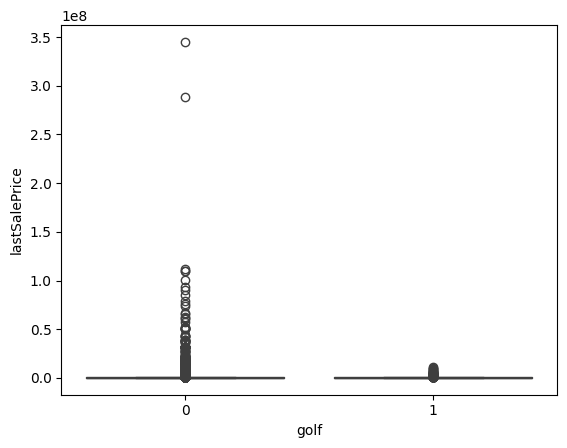

In [ ]:
# Visualizing golf and price

sns.boxplot(data=data, x='golf', y='lastSalePrice')
plt.show()

Conclusions:
- few properties with golf
- noisy data in this area
- unclear relationships

Next step: Does lot size correlate with price for condos? It may make sense to take lot size out of the equation for condos.

In [ ]:
condos.shape

(21213, 28)

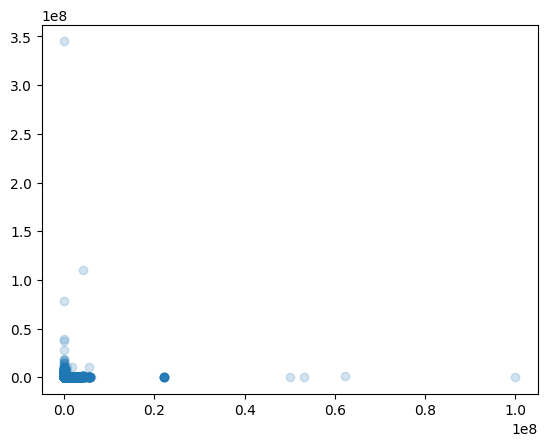

In [ ]:
plt.scatter(x=condos['lotSize'], y=condos['lastSalePrice'], alpha=0.2)
plt.show()

In [ ]:
# Investigating a few large lots on Zillow/Google

condos[condos['lotSize'] > 20000000].head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate
625,"3628-Muirfield-Ct,-New-Port-Richey,-FL-34655","3628 Muirfield Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.21,-82.66,Condo,2.00,...,1,0,1.00,1,False,1.00,None,33.00,2024-03,0.04
15216,"3445-Niblick-Ct,-New-Port-Richey,-FL-34655","3445 Niblick Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.21,-82.66,Condo,2.00,...,1,0,1.00,1,False,1.00,None,39.00,2024-03,0.04
20123,"5973-Terrace-Park-Dr-N,-Unit-209,-Saint-Peters...","5973 Terrace Park Dr N, Unit 209, Saint Peters...",Saint Petersburg,FL,33709,Pinellas,27.83,-82.75,Condo,2.00,...,1,0,1.00,1,False,1.00,Average,45.00,2024-04,0.05
29161,"3734-River-Oaks-Ct,-New-Port-Richey,-FL-34655","3734 River Oaks Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.21,-82.67,Condo,2.00,...,1,0,1.00,1,False,1.00,None,41.00,2024-04,0.05
32126,"271-Sapphire-Lake-Dr,-Unit-101,-Bradenton,-FL-...","271 Sapphire Lake Dr, Unit 101, Bradenton, FL ...",Bradenton,FL,34209,Manatee,27.50,-82.68,Condo,3.00,...,1,0,1.00,1,False,1.00,None,12.00,2024-04,0.05


There is no apparent correlation: 3/5 of these are clearly next to golf courses, but two are not. It might make the most sense to make lot size 0 and trust the location data to account for the price differences.

In [ ]:
# Assigning 0 to lotSize for all condos

data.loc[data["propertyType"] == "Condo", "lotSize"] = 0

In [ ]:
# Looking at lot size for single family homes

single_family = data[data['propertyType'] == 'Single Family']
single_family.shape

(91903, 29)

count        90,451.00
mean         30,284.68
std       2,703,413.47
min               1.00
25%           6,000.00
50%           8,250.00
75%          10,890.00
max     600,000,000.00
Name: lotSize, dtype: float64


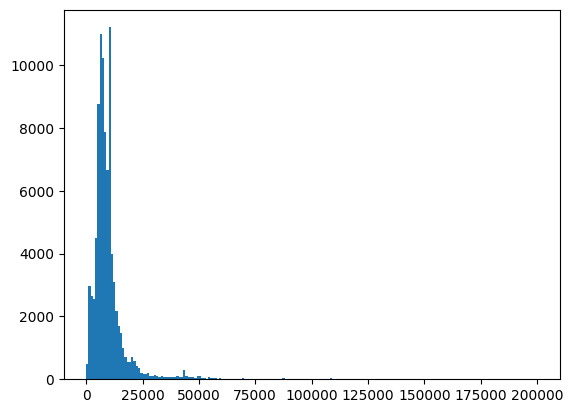

In [ ]:
# Distribution of lot size for single family

print(single_family['lotSize'].describe())

plt.hist(single_family['lotSize'], bins=200,range=(0, 200000))
plt.show()

In [ ]:
# Considering dropping outliers for this and limiting scope of project to typical homes for average buyer

# EDA on sale prices

In [ ]:
data['lastSalePrice'].describe()

count       120,533.00
mean        565,610.61
std       1,977,707.64
min             310.00
25%         257,000.00
50%         370,000.00
75%         545,000.00
max     345,000,000.00
Name: lastSalePrice, dtype: float64

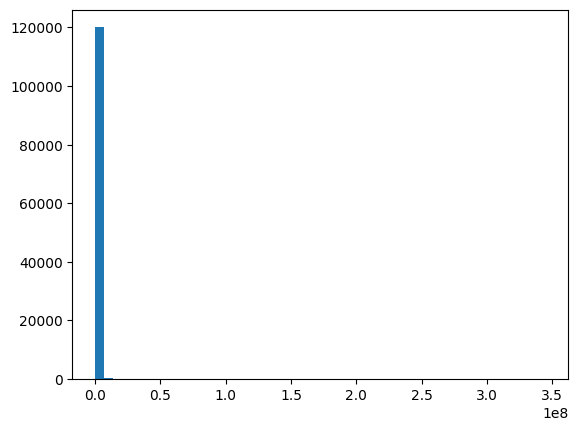

In [ ]:
plt.hist(data['lastSalePrice'], bins=50)
plt.show()

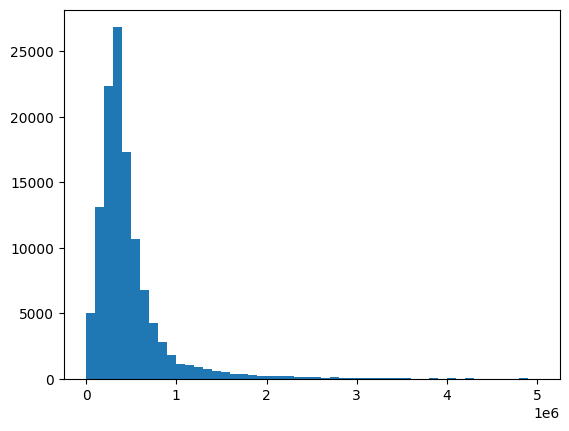

In [ ]:
plt.hist(data['lastSalePrice'], bins=50, range=(0,5000000))
plt.show()


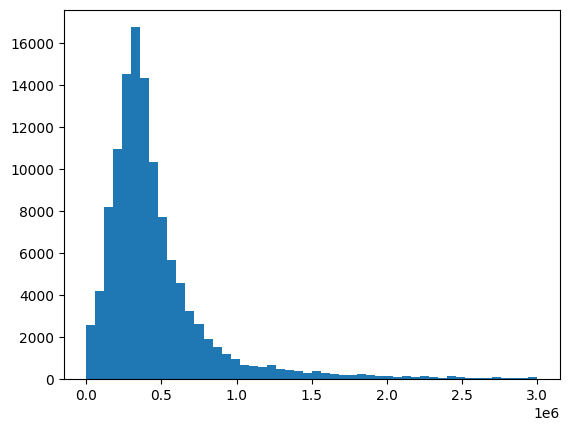

In [ ]:
plt.hist(data['lastSalePrice'], bins=50, range=(0,3000000))
plt.show()

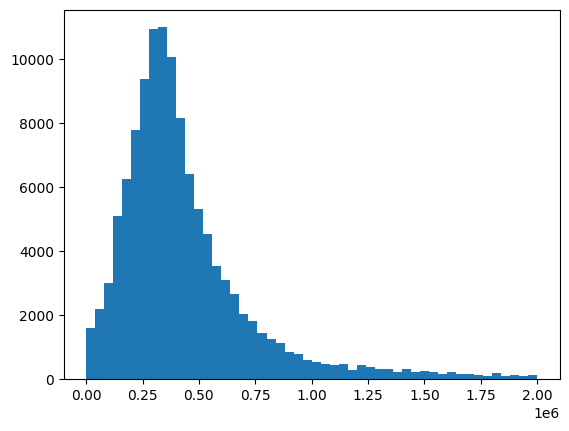

In [ ]:
plt.hist(data['lastSalePrice'], bins=50, range=(0,2000000))
plt.show()

# EDA on unitCount

In [ ]:
data['unitCount'].describe()

count   92,383.00
mean         1.11
std         19.15
min          1.00
25%          1.00
50%          1.00
75%          1.00
max      5,760.00
Name: unitCount, dtype: float64

Massive range of values, but the majority of properties are single unit.

# more EDA on propertyType

In [ ]:
data['propertyType'].value_counts()

propertyType
Single Family    91903
Condo            21213
Manufactured      3378
Multi-Family      2226
Townhouse         1813
Name: count, dtype: int64

Most properties are condo or single family.

In [ ]:
# Looking at propertyType --> Manufactured

manufactured = data[data['propertyType'] == 'Manufactured']
manufactured.shape

(3378, 29)

In [ ]:
manufactured.describe()

,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,unitCount,years_old,t_rate,golf
count,"3,378.00","3,378.00","3,378.00","3,378.00","3,378.00","3,336.00","3,378.00","3,378.00","3,378.00","3,378.00","3,378.00","3,378.00","3,378.00","2,907.00","3,374.00","3,378.00","3,378.00"
mean,28.22,-81.97,2.43,1.81,"1,147.17","31,603.27","1,987.31","180,929.79",0.73,0.72,0.08,1.00,0.59,1.00,37.73,0.04,0.01
std,1.20,1.07,0.72,0.45,415.63,"192,962.56",14.67,"434,381.43",0.45,0.45,0.27,0.05,0.49,0.07,14.62,0.00,0.10
min,24.57,-87.51,1.00,1.00,200.00,1.00,"1,900.00",600.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.04,0.00
25%,27.47,-82.38,2.00,2.00,849.75,"4,795.50","1,977.00","99,000.00",0.00,0.00,0.00,1.00,0.00,1.00,28.00,0.04,0.00
50%,28.22,-81.94,2.00,2.00,"1,125.00","7,328.50","1,986.00","150,000.00",1.00,1.00,0.00,1.00,1.00,1.00,39.00,0.04,0.00
75%,28.96,-81.56,3.00,2.00,"1,403.00","17,257.50","1,997.00","210,000.00",1.00,1.00,0.00,1.00,1.00,1.00,48.00,0.05,0.00
max,30.95,-80.06,7.00,4.00,"4,680.00","5,462,023.00","2,025.00","22,500,000.00",1.00,1.00,1.00,2.00,1.00,4.00,125.00,0.05,1.00


In [ ]:
# It looks like this is mostly single units, but the max is 5,000 for units

manufactured['unitCount'].value_counts()

unitCount
1.00    2899
2.00       7
4.00       1
Name: count, dtype: int64

In [ ]:
# Looking at the outlier

manufactured[manufactured['unitCount'] == 5000]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate,golf


From checking Zillow on this address, this is an entire condo complex--probably outside the scope of the project.

What are the single-unit properties in this category like?

In [ ]:
manufactured = manufactured[manufactured['unitCount'] == 1.0]
manufactured.head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate,golf
67,"8709-S-Meadowview-Cir,-Tampa,-FL-33625","8709 S Meadowview Cir, Tampa, FL 33625",Tampa,FL,33625,Hillsborough,28.05,-82.58,Manufactured,2.00,...,0,1.00,1,False,1.00,None,57.00,2024-03,0.04,0
97,"3141-Old-Farm-House-Dr,-North-Fort-Myers,-FL-3...","3141 Old Farm House Dr, North Fort Myers, FL 3...",North Fort Myers,FL,33917,Lee,26.71,-81.90,Manufactured,2.00,...,0,1.00,1,False,1.00,None,42.00,2024-03,0.04,0
98,"128-Torch-Ln,-North-Fort-Myers,-FL-33917","128 Torch Ln, North Fort Myers, FL 33917",North Fort Myers,FL,33917,Lee,26.69,-81.86,Manufactured,2.00,...,0,1.00,1,False,1.00,None,61.00,2024-03,0.04,0
137,"16-Golden-Gate-Cir,-Port-Orange,-FL-32129","16 Golden Gate Cir, Port Orange, FL 32129",Port Orange,FL,32129,Volusia,29.14,-81.02,Manufactured,3.00,...,1,1.00,1,False,1.00,None,34.00,2024-03,0.04,0
296,"1100-Belcher-Rd-S,-Lot-371,-Largo,-FL-33771","1100 Belcher Rd S, Lot 371, Largo, FL 33771",Largo,FL,33771,Pinellas,27.91,-82.75,Manufactured,2.00,...,0,1.00,1,True,1.00,None,51.00,2024-03,0.04,0


Looking at some of these on Zillow, they seem to be mostly mobile homes with a few single family homes mixed in. 

This category may be fine for the model.

# EDA on multiFamily

In [ ]:
multiFamily = data[data['propertyType'] == 'Multi-Family']
multiFamily.shape

(2226, 29)

In [ ]:
multiFamily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2226 entries, 26 to 145609
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                2226 non-null   object             
 1   formattedAddress  2226 non-null   object             
 2   city              2226 non-null   object             
 3   state             2226 non-null   object             
 4   zipCode           2226 non-null   object             
 5   county            2225 non-null   object             
 6   latitude          2226 non-null   float64            
 7   longitude         2226 non-null   float64            
 8   propertyType      2226 non-null   object             
 9   bedrooms          2226 non-null   float64            
 10  bathrooms         2226 non-null   float64            
 11  squareFootage     2226 non-null   float64            
 12  lotSize           2151 non-null   float64            
 13  yearB

In [ ]:
# Looking at range of sale values

# plt.scatter(x=multiFamily.id, y=multiFamily.lastSalePrice)
# plt.show()

In [ ]:
# What are the 100000000+ million dollar places, and the other outliers over 20,000,000?

multiFamily[multiFamily.lastSalePrice > 20000000]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate,golf
1339,"1809-Jackson-St,-Unit-619,-Hollywood,-FL-33020","1809 Jackson St, Unit 619, Hollywood, FL 33020",Hollywood,FL,33020,Broward,26.01,-80.14,Multi-Family,2.00,...,0,12.00,1,False,NaN,None,1.00,2024-03,0.04,0
15217,"3317-Broadway,-West-Palm-Beach,-FL-33407","3317 Broadway, West Palm Beach, FL 33407",West Palm Beach,FL,33407,Palm Beach,26.74,-80.06,Multi-Family,6.00,...,0,2.00,1,False,NaN,None,97.00,2024-03,0.04,0
63068,"1345-W-28th-St,-Apt-2,-Hialeah,-FL-33010","1345 W 28th St, Apt 2, Hialeah, FL 33010",Hialeah,FL,33010,Miami-Dade,25.85,-80.31,Multi-Family,2.00,...,0,1.00,0,False,NaN,None,57.00,2024-05,0.04,0
104642,"1495-Spring-Harbor-Dr,-Delray-Beach,-FL-33445","1495 Spring Harbor Dr, Delray Beach, FL 33445",Delray Beach,FL,33445,Palm Beach,26.44,-80.09,Multi-Family,1.00,...,0,1.00,0,False,NaN,None,34.00,2024-07,0.04,0
128826,"7960-Pine-Crossings-Cir,-Orlando,-FL-32807","7960 Pine Crossings Cir, Orlando, FL 32807",Orlando,FL,32807,Orange,28.55,-81.28,Multi-Family,2.00,...,1,2.00,1,True,14.00,None,39.00,2024-09,0.04,0


From Zillow research, these seem to be either large apartment buildings or innacurate records.

In [ ]:
# Looking at the 10 to 20 million range

multiFamily[(multiFamily.lastSalePrice < 20000000) & (multiFamily.lastSalePrice > 10000000)]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate,golf
74569,"11900-Nw-19th-Ave,-Miami,-FL-33167","11900 Nw 19th Ave, Miami, FL 33167",Miami,FL,33167,Miami-Dade,25.88,-80.23,Multi-Family,128.00,...,0,2.00,1,False,3.00,None,17.00,2024-05,0.04,1
125950,"243-Ne-12th-Ave,-Homestead,-FL-33030","243 Ne 12th Ave, Homestead, FL 33030",Homestead,FL,33030,Miami-Dade,25.47,-80.46,Multi-Family,62.00,...,0,2.00,0,False,10.00,None,32.00,2024-08,0.04,0
133318,"3681-Sw-60th-Ter,-Apt-4,-Davie,-FL-33314","3681 Sw 60th Ter, Apt 4, Davie, FL 33314",Davie,FL,33314,Broward,26.08,-80.23,Multi-Family,6.00,...,0,2.00,0,0,4.00,None,56.00,2024-11,0.04,0
137460,"14555-Ne-6th-Ave,-Unit-106,-North-Miami,-FL-33161","14555 Ne 6th Ave, Unit 106, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.91,-80.19,Multi-Family,1.00,...,0,1.00,0,0,NaN,None,62.00,2024-12,0.04,0
137464,"14555-Ne-6th-Ave,-Unit-225,-North-Miami,-FL-33161","14555 Ne 6th Ave, Unit 225, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.91,-80.19,Multi-Family,1.00,...,0,1.00,0,0,NaN,None,62.00,2024-12,0.04,0
137466,"14555-Ne-6th-Ave,-Unit-105,-North-Miami,-FL-33161","14555 Ne 6th Ave, Unit 105, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.91,-80.19,Multi-Family,1.00,...,0,1.00,0,0,NaN,None,62.00,2024-12,0.04,0


There is a combination of full apartment buildings and individual units. 

Recommend dropping this category--outside of the scope of a web app for home buyers and likely to misinform the model.

# EDA on Townhouse

In [ ]:
townhouse = data[data['propertyType'] == 'Townhouse']
townhouse.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1813 entries, 1 to 145450
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                1813 non-null   object             
 1   formattedAddress  1813 non-null   object             
 2   city              1813 non-null   object             
 3   state             1813 non-null   object             
 4   zipCode           1813 non-null   object             
 5   county            1802 non-null   object             
 6   latitude          1813 non-null   float64            
 7   longitude         1813 non-null   float64            
 8   propertyType      1813 non-null   object             
 9   bedrooms          1813 non-null   float64            
 10  bathrooms         1813 non-null   float64            
 11  squareFootage     1813 non-null   float64            
 12  lotSize           1373 non-null   float64            
 13  yearBu

In [ ]:
townhouse.describe()

,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,unitCount,years_old,t_rate,golf
count,"1,813.00","1,813.00","1,813.00","1,813.00","1,813.00","1,373.00","1,813.00","1,813.00","1,813.00","1,813.00","1,813.00","1,813.00","1,813.00",679.00,"1,719.00","1,813.00","1,813.00"
mean,27.76,-81.49,2.75,2.41,"1,560.84","51,573.04","2,004.70","1,084,959.39",0.30,0.27,0.03,1.31,0.26,1.46,21.35,0.04,0.01
std,1.49,1.50,0.65,0.56,561.74,"1,062,923.00",18.73,"3,867,448.71",0.46,0.45,0.17,0.51,0.44,8.37,18.67,0.00,0.07
min,24.55,-87.44,1.00,1.00,550.00,59.00,"1,900.00",410.00,0.00,0.00,0.00,1.00,0.00,1.00,-1.00,0.04,0.00
25%,26.40,-82.12,2.00,2.00,"1,276.00","1,742.00","1,986.00","253,000.00",0.00,0.00,0.00,1.00,0.00,1.00,2.00,0.04,0.00
50%,27.86,-81.40,3.00,2.50,"1,507.00","2,221.00","2,007.00","342,700.00",0.00,0.00,0.00,1.00,0.00,1.00,19.00,0.04,0.00
75%,28.50,-80.28,3.00,2.50,"1,750.00","3,620.00","2,024.00","478,500.00",1.00,1.00,0.00,2.00,1.00,1.00,39.00,0.04,0.00
max,30.96,-80.04,6.00,9.00,"16,783.00","37,940,760.00","2,026.00","35,714,286.00",1.00,1.00,1.00,4.00,1.00,200.00,125.00,0.07,1.00


Nothing here seems too unusual, aside from max yearBuilt is 2026--will investigate that whole column. This category may be fine to use.

# EDA on yearBuilt

In [ ]:
data['yearBuilt'].info()

<class 'pandas.core.series.Series'>
Index: 120533 entries, 0 to 145616
Series name: yearBuilt
Non-Null Count   Dtype  
--------------   -----  
120533 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [ ]:
data['yearBuilt'].describe()

count   120,533.00
mean      1,990.36
std          24.27
min         202.00
25%       1,974.00
50%       1,990.00
75%       2,007.00
max       2,028.00
Name: yearBuilt, dtype: float64

In [ ]:
# The min is 202--investigating further

data[data['yearBuilt'] == 202]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate,golf
121788,"4451-Sw-170th-Street-Rd,-Ocala,-FL-34473","4451 Sw 170th Street Rd, Ocala, FL 34473",Ocala,FL,34473,Marion,28.97,-82.20,Single Family,3.00,...,0,1.00,0,False,NaN,None,"1,823.00",2024-07,0.04,0


In [ ]:
# Filling in year from Zillow

data.loc[121788, 'yearBuilt'] = 2023

In [ ]:
# Properties with year built in future

data[(data['yearBuilt'] >= 2026) & (data['yearBuilt'] <= 2028)]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate,golf
0,"1960-S-Ocean-Blvd,-Manalapan,-FL-33462","1960 S Ocean Blvd, Manalapan, FL 33462",Manalapan,FL,33462,Palm Beach,26.55,-80.04,Single Family,8.00,...,0,1.00,0,False,NaN,None,-3.00,2024-03,0.04,0
267,"145-Nw-9th-St,-Boca-Raton,-FL-33432","145 Nw 9th St, Boca Raton, FL 33432",Boca Raton,FL,33432,Palm Beach,26.36,-80.09,Single Family,5.00,...,0,1.00,1,False,1.00,None,-1.00,2024-03,0.04,0
10070,"10670-Sw-26th-Ct,-Davie,-FL-33328","10670 Sw 26th Ct, Davie, FL 33328",Davie,FL,33328,Broward,26.09,-80.29,Single Family,7.00,...,0,1.00,1,False,1.00,None,-1.00,2024-03,0.04,0
14045,"303-N-Riverside-Dr,-Indialantic,-FL-32903","303 N Riverside Dr, Indialantic, FL 32903",Indialantic,FL,32903,Brevard,28.09,-80.58,Townhouse,3.00,...,1,1.00,1,False,1.00,None,-1.00,2024-03,0.04,0
46028,"939-Eve-St,-Delray-Beach,-FL-33483","939 Eve St, Delray Beach, FL 33483",Delray Beach,FL,33483,Palm Beach,26.44,-80.07,Single Family,6.00,...,0,1.00,1,1,1.00,Water,-1.00,2024-04,0.05,0
55187,"910-N-Venetian-Dr,-Miami-Beach,-FL-33139","910 N Venetian Dr, Miami Beach, FL 33139",Miami Beach,FL,33139,Miami-Dade,25.79,-80.18,Single Family,5.00,...,0,1.00,0,False,1.00,None,-1.00,2024-05,0.04,0
98992,"3929-Belmont-St,-Fort-Myers,-FL-33916","3929 Belmont St, Fort Myers, FL 33916",Fort Myers,FL,33916,Lee,26.66,-81.83,Single Family,4.00,...,0,1.00,0,0,NaN,None,-3.00,2024-06,0.04,0
125767,"2267-Windsor-Rd,-Palm-Beach-Gardens,-FL-33410","2267 Windsor Rd, Palm Beach Gardens, FL 33410",Palm Beach Gardens,FL,33410,Palm Beach,26.87,-80.07,Single Family,5.00,...,0,1.00,0,False,NaN,None,-1.00,2024-08,0.04,0
126074,"Eve-Cir,-Santa-Rosa-Beach,-FL-32459","Eve Cir, Santa Rosa Beach, FL 32459",Santa Rosa Beach,FL,32459,Walton,30.37,-86.11,Single Family,5.00,...,0,1.00,0,False,NaN,None,-1.00,2024-08,0.04,0
126126,"409-Palm-Trl,-Delray-Beach,-FL-33483","409 Palm Trl, Delray Beach, FL 33483",Delray Beach,FL,33483,Palm Beach,26.47,-80.06,Single Family,4.00,...,0,2.00,1,True,1.00,None,-1.00,2024-08,0.04,0


In [ ]:
# These are projected builds. Dropping these rows

data = data[data['yearBuilt'] <= 2025]

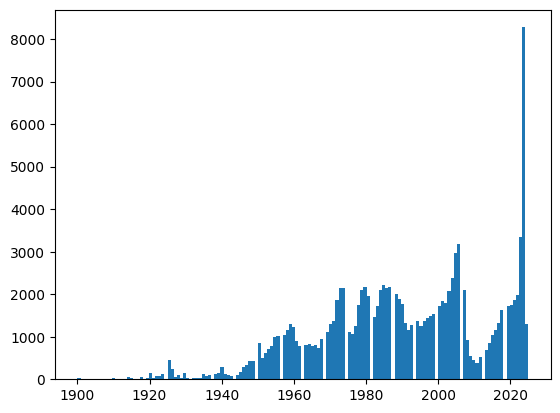

In [ ]:
plt.hist(data['yearBuilt'], bins=145, range=(1900, 2025))
plt.show()

In [ ]:
# Dropping values below 1920 (this improved the XGBoost by a few points)

data = data[data['yearBuilt'] > 1920]

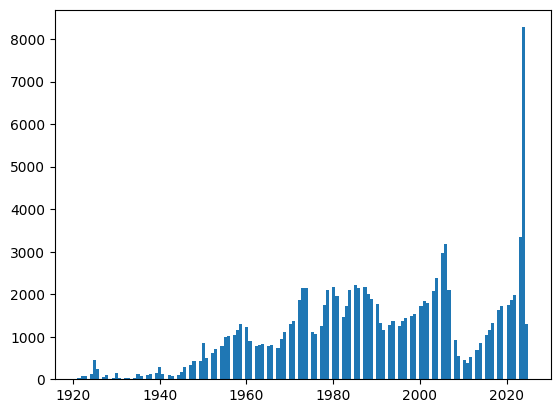

In [ ]:
plt.hist(data['yearBuilt'], bins=145)
plt.show()

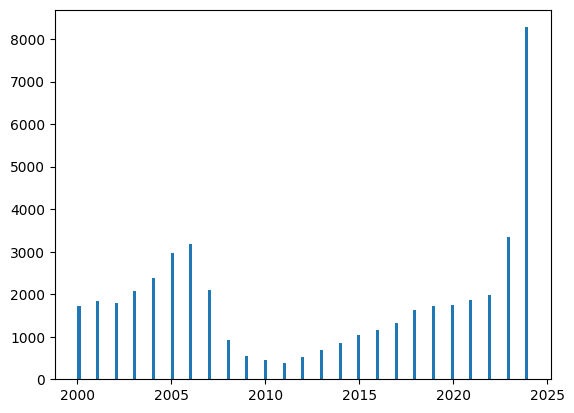

In [ ]:
plt.hist(data['yearBuilt'], bins=145, range=(2000,2024))
plt.show()

A few from the 19th C, some from first half 20th, most from 2024. 

In [ ]:
# Bedrooms

len(data['bedrooms']. value_counts())

32

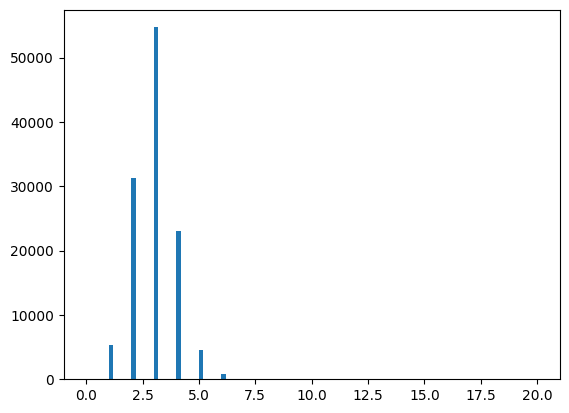

In [ ]:
plt.hist(data['bedrooms'], bins=100, range=(0, 20))
plt.show()

In [ ]:
# # Limiting to 10 bedrooms max

# data = data[data['bedrooms'] <= 10]

# EDA on pool

In [ ]:
data['pool'].value_counts()

pool
False           87849
0               19350
True            10773
1                2052
Type Unknown        9
Inground            8
Pool/spa            1
Name: count, dtype: int64

In [ ]:
data[data['pool'] == 'Type Unknown']

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,garage,pool,unitCount,viewType,years_old,year_month,t_rate,golf
11307,"1221-Biarritz-Dr,-Miami-Beach,-FL-33141","1221 Biarritz Dr, Miami Beach, FL 33141",Miami Beach,FL,33141,Miami-Dade,25.85,-80.13,Single Family,4.00,...,0,1.00,0,Type Unknown,1.00,None,86.00,2024-03,0.04,0
18186,"6300-S-Pointe-Blvd,-Apt-201,-Fort-Myers,-FL-33919","6300 S Pointe Blvd, Apt 201, Fort Myers, FL 33919",Fort Myers,FL,33919,Lee,26.55,-81.90,Condo,2.00,...,0,1.00,1,Type Unknown,1.00,Street,46.00,2024-03,0.04,0
21209,"358-Ne-Genesee-Ave,-Port-Saint-Lucie,-FL-34983","358 Ne Genesee Ave, Port Saint Lucie, FL 34983",Port Saint Lucie,FL,34983,St. Lucie,27.34,-80.34,Single Family,3.00,...,0,1.00,1,Type Unknown,1.00,None,38.00,2024-04,0.05,0
32705,"3012-Brougham-Ave,-Jacksonville,-FL-32246","3012 Brougham Ave, Jacksonville, FL 32246",Jacksonville,FL,32246,Duval,30.29,-81.46,Single Family,3.00,...,0,1.00,1,Type Unknown,1.00,None,22.00,2024-04,0.05,0
57747,"1767-Oak-Pond-Ct,-Oldsmar,-FL-34677","1767 Oak Pond Ct, Oldsmar, FL 34677",Oldsmar,FL,34677,Pinellas,28.04,-82.69,Single Family,4.00,...,0,2.00,1,Type Unknown,1.00,None,25.00,2024-05,0.04,0
61879,"3761-Sw-1st-St,-Fort-Lauderdale,-FL-33312","3761 Sw 1st St, Fort Lauderdale, FL 33312",Fort Lauderdale,FL,33312,Broward,26.12,-80.20,Single Family,4.00,...,0,1.00,0,Type Unknown,1.00,None,66.00,2024-05,0.04,0
81257,"721-Ne-137th-St,-North-Miami,-FL-33161","721 Ne 137th St, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.90,-80.18,Single Family,3.00,...,0,1.00,0,Type Unknown,1.00,None,78.00,2024-05,0.04,0
103662,"7907-11th-Ave-NW,-Bradenton,-FL-34209","7907 11th Ave NW, Bradenton, FL 34209",Bradenton,FL,34209,Manatee,27.51,-82.64,Single Family,3.00,...,1,1.00,1,Type Unknown,1.00,None,43.00,2024-07,0.04,0
121900,"810-Se-5th-Ter,-Pompano-Beach,-FL-33060","810 Se 5th Ter, Pompano Beach, FL 33060",Pompano Beach,FL,33060,Broward,26.22,-80.11,Single Family,3.00,...,0,1.00,1,Type Unknown,1.00,None,57.00,2024-07,0.04,0


In [ ]:
# Checked on Zillow/Google for pools in the Type Unknown category--all but one have pools. Assigning 0 to that one.

data.loc[18186, 'pool'] = 0

In [ ]:
data.iloc[18186]

id                  400-E-Colonial-Dr,-Apt-304,-Orlando,-FL-32803
formattedAddress    400 E Colonial Dr, Apt 304, Orlando, FL 32803
city                                                      Orlando
state                                                          FL
zipCode                                                     32803
county                                                     Orange
latitude                                                    28.55
longitude                                                  -81.37
propertyType                                                Condo
bedrooms                                                     2.00
bathrooms                                                    2.00
squareFootage                                            1,189.00
lotSize                                                      0.00
yearBuilt                                                1,975.00
subdivision                                PARK LAKE TOWERS CONDO
lastSaleDa

In [ ]:
# Changing the multiple ways to designate pool into 1/0

bool_mapper = {
    '1':1,
    '0':0,
    'True':1,
    'False':0,
    'Inground':1,
    'Type Unknown': 1,
    'Pool/spa':1
}

data['pool'] = data['pool'].map(bool_mapper).fillna(0).astype(int)

In [ ]:
data['pool'].head()

1    1
2    0
3    0
4    0
5    1
Name: pool, dtype: int64

In [ ]:
data['pool'].isna().any()

np.False_

In [ ]:
# Choosing Miami, how does having a pool relate to sale price? 

miami = data[data['city'] == 'Miami']
miami.shape

(4400, 29)

In [ ]:
miami['pool'].value_counts()

pool
0    4141
1     259
Name: count, dtype: int64

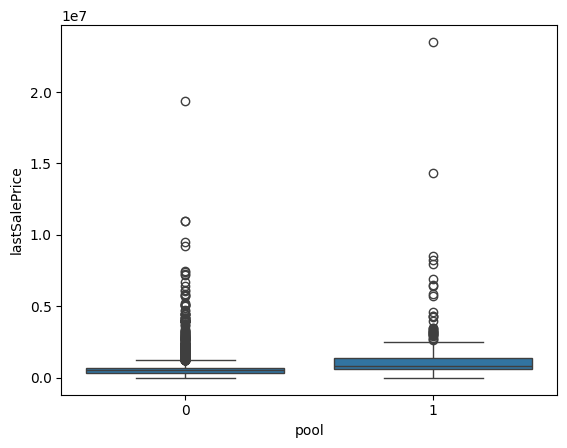

In [ ]:
# Visualzing effect of pool on price in Miami

sns.boxplot(data=miami, x='pool', y='lastSalePrice')
plt.show()

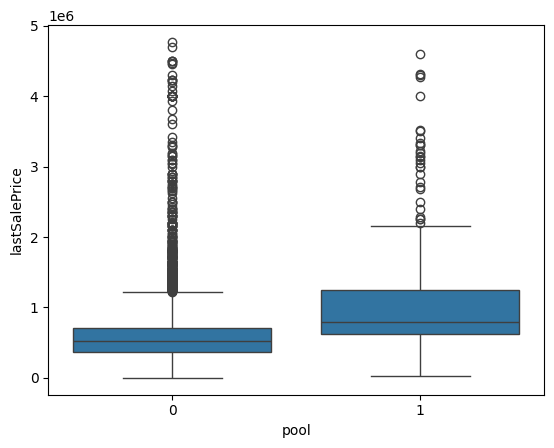

In [ ]:
# Filtering price range to under 5 million

miami_filtered = miami[miami['lastSalePrice'] < 5000000]

sns.boxplot(data=miami_filtered, x='pool', y='lastSalePrice')
plt.show()

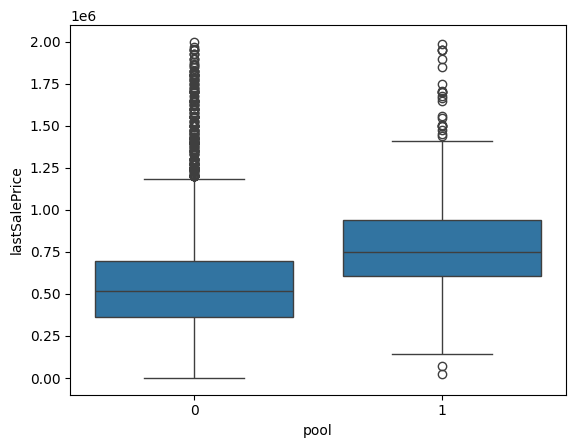

In [ ]:
# Filtering price range to under 2 million

miami_filtered = miami[miami['lastSalePrice'] < 2000000]

sns.boxplot(data=miami_filtered, x='pool', y='lastSalePrice')
plt.show()

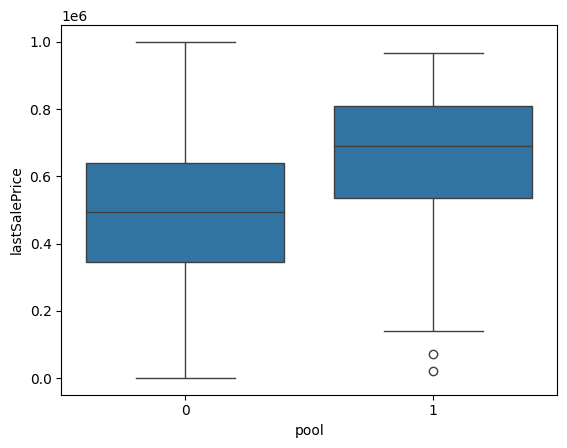

In [ ]:
# Filtering price range to under 1 million

miami_filtered = miami[miami['lastSalePrice'] < 1000000]

sns.boxplot(data=miami_filtered, x='pool', y='lastSalePrice')
plt.show()

# Modeling

In [ ]:
data['county'].value_counts().head(60)

county
Broward         10034
Palm Beach       8903
Miami-Dade       8847
Hillsborough     7380
Lee              7097
Pinellas         6327
Duval            5981
Orange           5955
Polk             5200
Pasco            4409
Sarasota         3968
Volusia          3779
Brevard          3398
Manatee          3236
Marion           3204
Collier          2633
Osceola          2616
Lake             2450
Charlotte        2346
Seminole         2320
Saint Johns      1938
Saint Lucie      1438
Bay              1414
Escambia         1207
Flagler          1173
Hernando         1154
Clay             1107
Alachua          1028
Okaloosa         1022
Leon              994
Citrus            958
Indian River      936
Martin            799
Walton            660
Sumter            628
St. Lucie         585
Highlands         558
Nassau            459
Monroe            422
St. Johns         295
Santa Rosa        202
Putnam            165
Hendry            129
Wakulla            96
Columbia           77
Gul

In [ ]:
data.city.value_counts().head(10)

city
Jacksonville        5600
Miami               4400
Orlando             3909
Tampa               3661
Naples              2305
Ocala               2292
Cape Coral          2283
Saint Petersburg    2207
Kissimmee           2123
Fort Myers          1965
Name: count, dtype: int64

In [ ]:
city_counts = data.city.value_counts()
big_cities = city_counts[city_counts >= 1966].index

filtered = data[data.city.isin(big_cities)]

filtered.shape

(28780, 29)

In [ ]:
print(city_counts)

city
Jacksonville        5600
Miami               4400
Orlando             3909
Tampa               3661
Naples              2305
                    ... 
Little Torch Key       1
Fort Denaud            1
Lawtey                 1
Pt Charlotte           1
Ebro                   1
Name: count, Length: 546, dtype: int64


In [ ]:
filtered['propertyType'].value_counts()

propertyType
Single Family    22434
Condo             4996
Multi-Family       667
Townhouse          367
Manufactured       316
Name: count, dtype: int64

In [ ]:
property_types = ['Single Family','Condo','Manufactured','Townhouse']
filtered = filtered[filtered['propertyType'].isin(property_types)]
filtered['propertyType'].value_counts()

propertyType
Single Family    22434
Condo             4996
Townhouse          367
Manufactured       316
Name: count, dtype: int64

In [ ]:
num_var = ['bedrooms','bathrooms','squareFootage','pool','latitude','longitude','floorCount','lastSalePrice','lotSize','t_rate','cooling','heating','fireplace','years_old','garage']

model_var = ['zipCode','latitude','longitude','propertyType','bedrooms','bathrooms','squareFootage','lotSize','lastSalePrice','pool','t_rate','cooling','heating','fireplace','garage','floorCount','years_old']

filtered = filtered[model_var]
filtered.shape

(28113, 17)

In [ ]:
# # Scatterplots for num_var

# columns = 3
# rows = -(-len(num_var) // columns)  

# fig, axes = plt.subplots(rows, columns, figsize=(18, 5 * rows))

# for i, col in enumerate(num_var):
#     x, y = divmod(i, columns)
#     sns.scatterplot(data=filtered, x=col, y='lastSalePrice', ax=axes[x, y])
#     axes[x, y].set_title(f'{col}')

# plt.subplots_adjust(hspace=0.8, wspace=0.8)

# plt.tight_layout()
# plt.show()

In [ ]:
# Setting range of home values

filtered = filtered[(filtered['lastSalePrice'] < 1500000) & (filtered['lastSalePrice'] > 10000)]

In [ ]:
# Getting dummies for cat_var

cat_var = ['propertyType','zipCode']

cat_data = pd.get_dummies(filtered[cat_var])

# Recreating the dataframe with the numerical and dummy columns 

filtered = pd.concat([filtered[num_var], cat_data], axis=1)

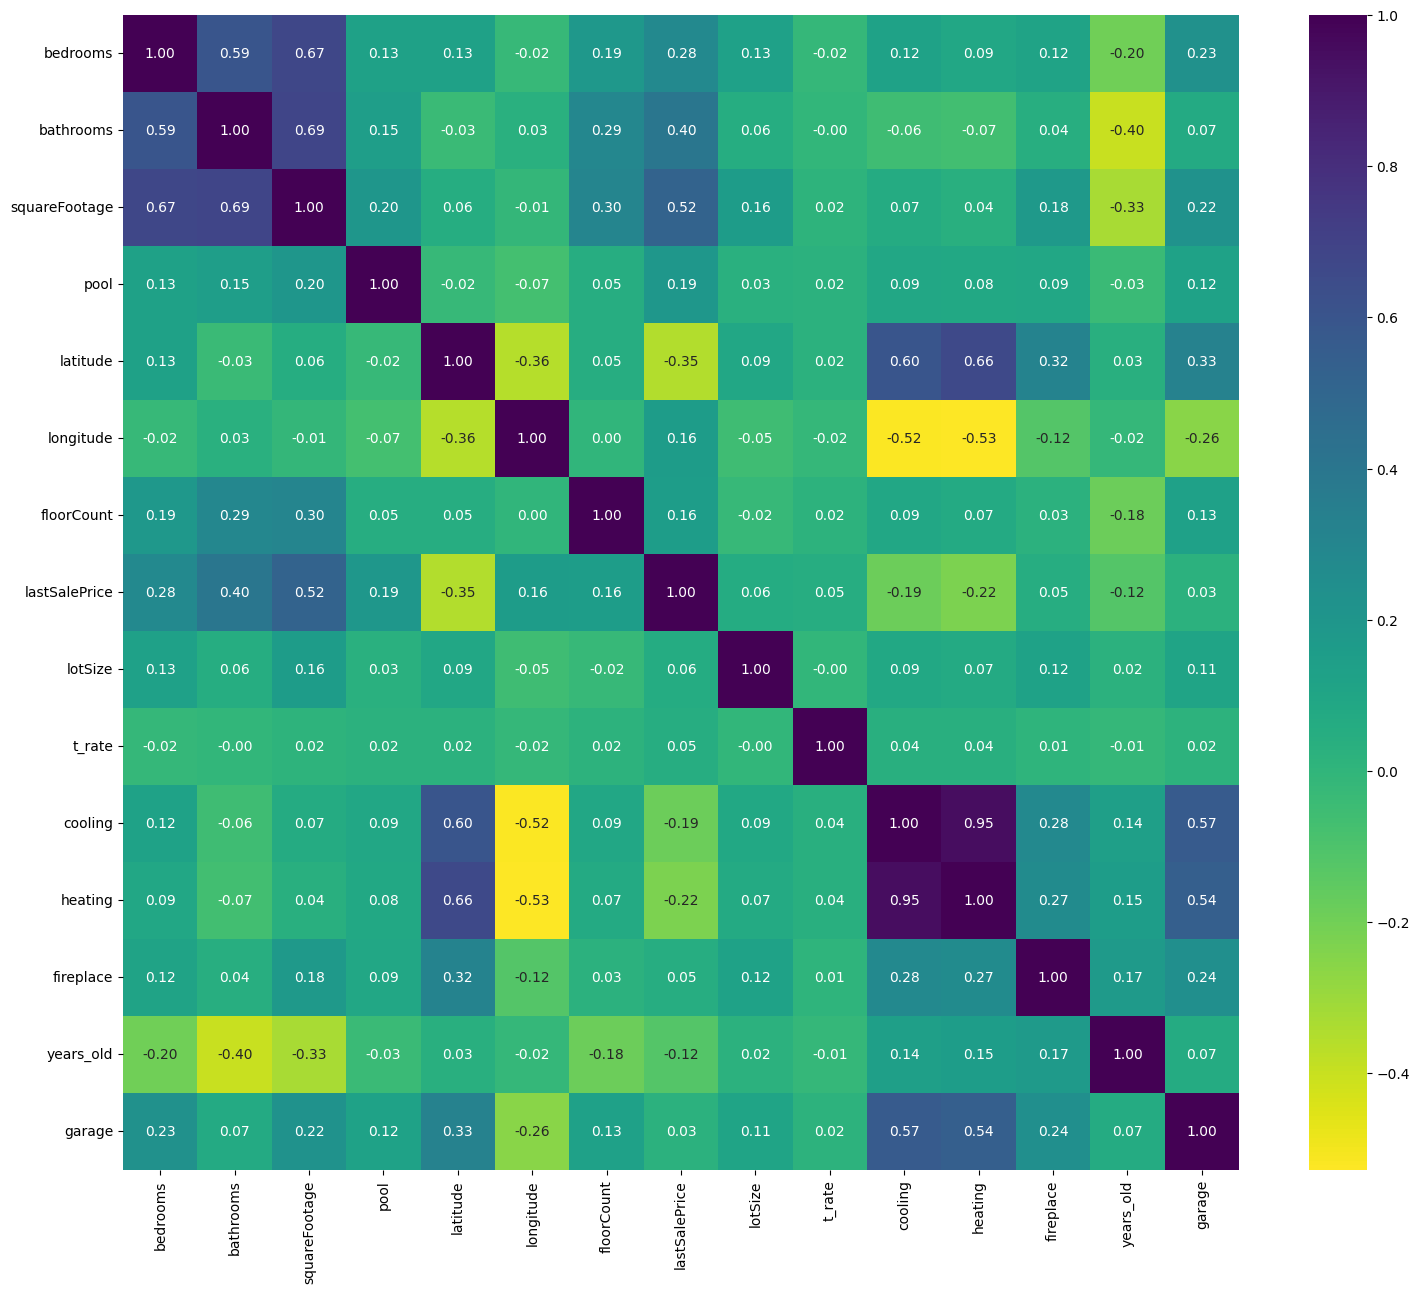

In [ ]:
corr = filtered[num_var].corr()

plt.figure(figsize=(18,15))

sns.heatmap(corr,annot=True, fmt=".2f", cmap="viridis_r")

plt.show()

In [ ]:
# Getting columns for dummy variables

cat_var = cat_data.columns.astype(str).tolist()

In [ ]:
# Features and target, splitting data

y = filtered['lastSalePrice']
X = filtered.drop(['lastSalePrice'], axis=1)

# # For app (switched this code over to matt_rentcast_4)

# model_columns = X.columns.tolist()

# dump(model_columns, open('/workspaces/mds8-final-project-bmh/src/model_columns.sav', 'wb'))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=17)

In [ ]:
# # Scaling numerical data

# num_var.remove('lastSalePrice')

# X_train_num = X_train[num_var]
# X_test_num = X_test[num_var]

# scaler = MinMaxScaler()

# X_train_scaled = scaler.fit_transform(X_train[num_var])
# X_test_scaled = scaler.transform(X_test[num_var])

# X_train_scaled = scaler.fit_transform(X_train_num)
# X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train_num.index, columns=X_train_num.columns)

# X_test_scaled = scaler.transform(X_test_num)
# X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test_num.index, columns=X_test_num.columns.astype(str))

In [ ]:
# Saving scaler to use in app

# dump(scaler, open('/workspaces/mds8-final-project-bmh/src/scaler.sav', 'wb'))

In [ ]:
# # Reassembling the fully processed X sets

# X_train_p = pd.concat([X_train_scaled, X_train[cat_var]], axis=1)
# X_test_p = pd.concat([X_test_scaled, X_test[cat_var]], axis=1)

In [ ]:
# # Linear Regression

# model = LinearRegression()
# model.fit(X_train_p, y_train)

# y_pred = model.predict(X_test_p)

# # print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
# print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
# print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

In [ ]:
# # Decision Tree Regressor

# dt_regressor = DecisionTreeRegressor()
# dt_regressor.fit(X_train_p, y_train)

# y_pred = dt_regressor.predict(X_test_p)

# print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
# print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

In [ ]:
# XGBoost Regressor

xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)

print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

RMSE: 131443.5628608809
Coefficient of determination: 0.7166142327183286


In [ ]:
dump(xgbr, open('../models/matt_test_xgb.sav', 'wb'))

In [ ]:
# # Random Forest Regressor

# rf_regressor = RandomForestRegressor()
# rf_regressor.fit(X_train_p, y_train)

# y_pred = rf_regressor.predict(X_test_p)

# print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
# print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

In [ ]:
# Loading cleaned data into a database

# conn = sqlite3.connect('/workspaces/mds8-final-project-bmh/data/processed/rentcast_FL_matt_cleaned.db')

# filtered.to_sql('cleaned_properties_matt', conn, if_exists='replace', index=False)

# conn.close()